In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Documents/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2025/ANESTESIOLOGIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 10 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=109.4, y1=114.8
Page 1, Q1, A: Yellow pixels: 941
Page 1, Q1, A: Total non-white pixels: 1104
Page 1, Q1, A: Yellow percentage: 85.2%


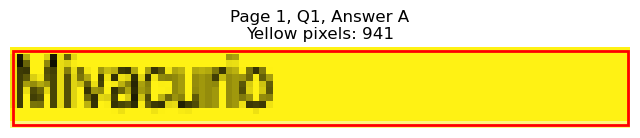

Page 1, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=125.4, y1=127.4
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 286
Page 1, Q1, B: Yellow percentage: 0.0%


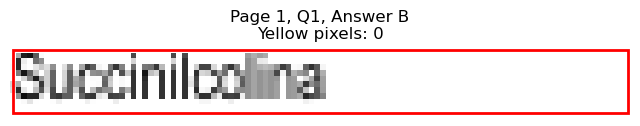

Page 1, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=366.1, y1=114.8
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 186
Page 1, Q1, C: Yellow percentage: 0.0%


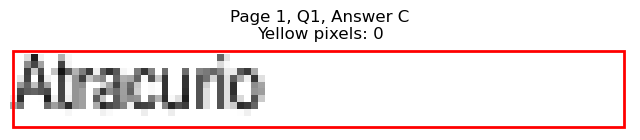

Page 1, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=370.7, y1=127.4
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 218
Page 1, Q1, D: Yellow percentage: 0.0%


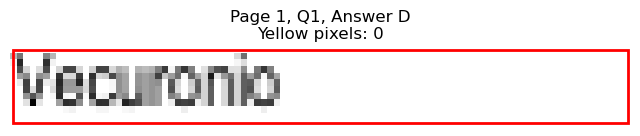


Page 1, Q1 - Selected Answer: A (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=154.1, y1=190.5
Page 1, Q2, A: Yellow pixels: 137
Page 1, Q2, A: Total non-white pixels: 547
Page 1, Q2, A: Yellow percentage: 25.0%


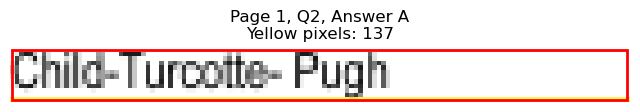

Page 1, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=99.4, y1=203.1
Page 1, Q2, B: Yellow pixels: 781
Page 1, Q2, B: Total non-white pixels: 904
Page 1, Q2, B: Yellow percentage: 86.4%


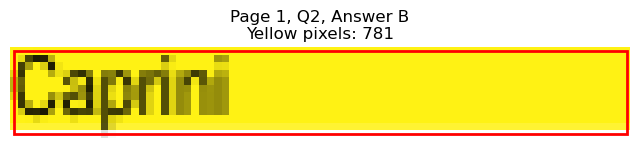

Page 1, Q2 - C: Detected box: x0=365.3, y0=179.5, x1=393.5, y1=190.5
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 124
Page 1, Q2, C: Yellow percentage: 0.0%


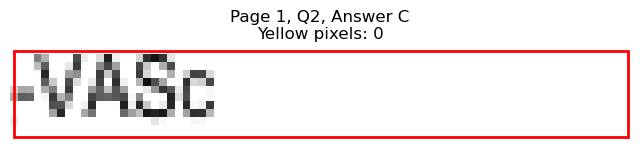

Page 1, Q2 - D: Detected box: x0=327.5, y0=192.1, x1=348.0, y1=203.1
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 97
Page 1, Q2, D: Yellow percentage: 0.0%


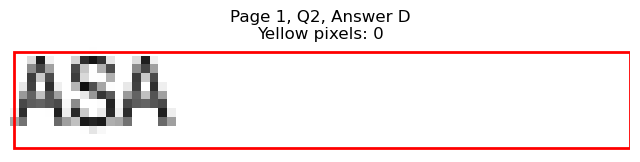


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=255.2, x1=143.5, y1=266.2
Page 1, Q3, A: Yellow pixels: 1056
Page 1, Q3, A: Total non-white pixels: 1386
Page 1, Q3, A: Yellow percentage: 76.2%


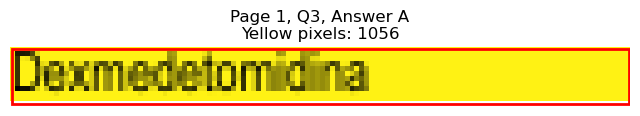

Page 1, Q3 - B: Detected box: x0=68.3, y0=267.8, x1=112.4, y1=278.8
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 240
Page 1, Q3, B: Yellow percentage: 0.0%


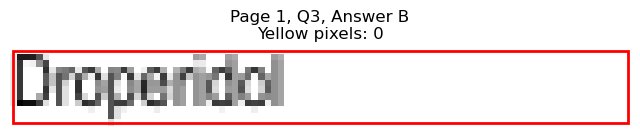

Page 1, Q3 - C: Detected box: x0=327.5, y0=255.2, x1=368.2, y1=266.2
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 215
Page 1, Q3, C: Yellow percentage: 0.0%


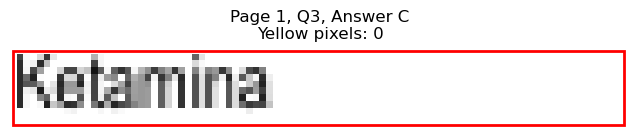

Page 1, Q3 - D: Detected box: x0=327.5, y0=267.8, x1=370.6, y1=278.8
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 222
Page 1, Q3, D: Yellow percentage: 0.0%


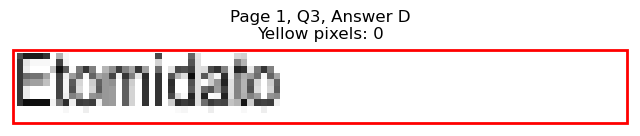


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=330.9, x1=113.4, y1=342.0
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 241
Page 1, Q4, A: Yellow percentage: 0.0%


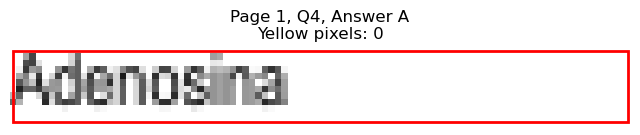

Page 1, Q4 - B: Detected box: x0=68.3, y0=343.6, x1=119.4, y1=354.7
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 269
Page 1, Q4, B: Yellow percentage: 0.0%


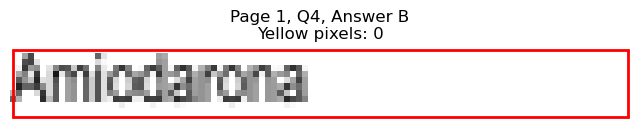

Page 1, Q4 - C: Detected box: x0=327.5, y0=330.9, x1=373.1, y1=342.0
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 321
Page 1, Q4, C: Yellow percentage: 0.0%


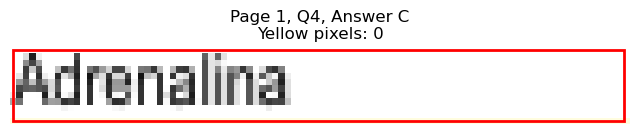

Page 1, Q4 - D: Detected box: x0=327.5, y0=343.6, x1=428.8, y1=354.7
Page 1, Q4, D: Yellow pixels: 1445
Page 1, Q4, D: Total non-white pixels: 1824
Page 1, Q4, D: Yellow percentage: 79.2%


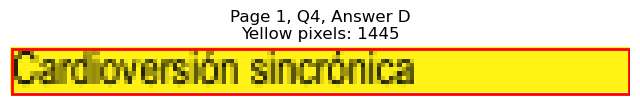


Page 1, Q4 - Selected Answer: D (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=394.0, x1=149.5, y1=405.1
Page 1, Q5, A: Yellow pixels: 1113
Page 1, Q5, A: Total non-white pixels: 1454
Page 1, Q5, A: Yellow percentage: 76.5%


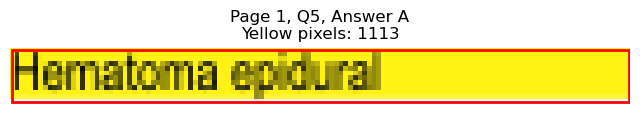

Page 1, Q5 - B: Detected box: x0=68.3, y0=406.6, x1=112.4, y1=417.7
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 243
Page 1, Q5, B: Yellow percentage: 0.0%


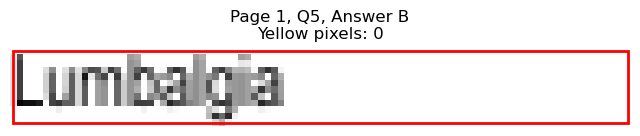

Page 1, Q5 - C: Detected box: x0=327.5, y0=394.0, x1=410.3, y1=405.1
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 391
Page 1, Q5, C: Yellow percentage: 0.0%


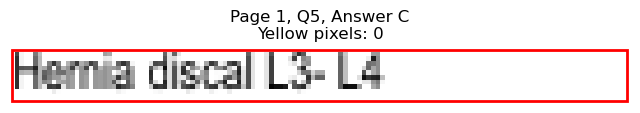

Page 1, Q5 - D: Detected box: x0=327.5, y0=406.6, x1=472.0, y1=417.7
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 755
Page 1, Q5, D: Yellow percentage: 0.0%


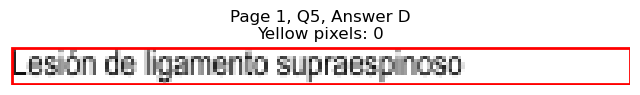


Page 1, Q5 - Selected Answer: A (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=469.8, x1=148.6, y1=480.8
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 429
Page 1, Q6, A: Yellow percentage: 0.0%


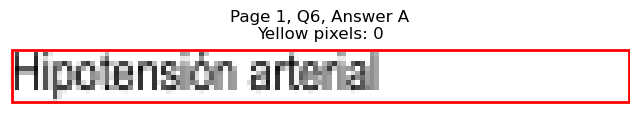

Page 1, Q6 - B: Detected box: x0=68.3, y0=482.5, x1=113.4, y1=493.5
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 241
Page 1, Q6, B: Yellow percentage: 0.0%


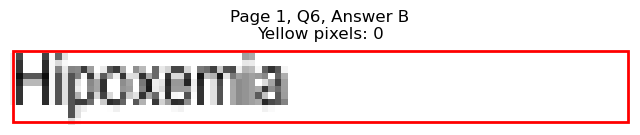

Page 1, Q6 - C: Detected box: x0=327.5, y0=469.8, x1=366.6, y1=480.8
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 279
Page 1, Q6, C: Yellow percentage: 0.0%


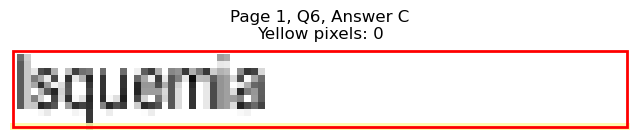

Page 1, Q6 - D: Detected box: x0=327.5, y0=482.5, x1=360.1, y1=493.5
Page 1, Q6, D: Yellow pixels: 789
Page 1, Q6, D: Total non-white pixels: 1008
Page 1, Q6, D: Yellow percentage: 78.3%


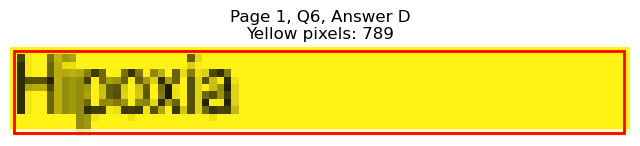


Page 1, Q6 - Selected Answer: D (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=545.5, x1=80.9, y1=556.5
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 51
Page 1, Q7, A: Yellow percentage: 0.0%


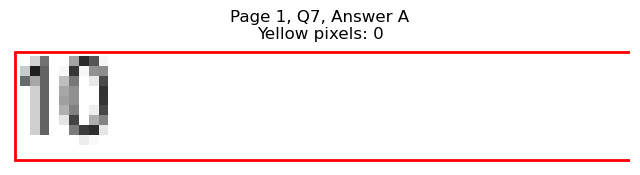

Page 1, Q7 - B: Detected box: x0=56.6, y0=558.2, x1=65.2, y1=569.2
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 77
Page 1, Q7, B: Yellow percentage: 0.0%


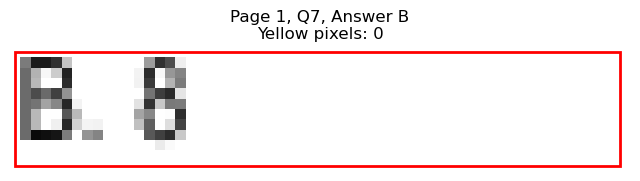

Page 1, Q7 - C: Detected box: x0=315.4, y0=545.5, x1=324.4, y1=556.5
Page 1, Q7, C: Yellow pixels: 614
Page 1, Q7, C: Total non-white pixels: 720
Page 1, Q7, C: Yellow percentage: 85.3%


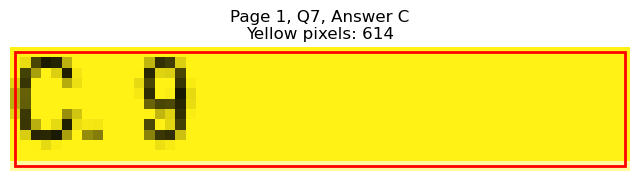

Page 1, Q7 - D: Detected box: x0=315.4, y0=558.2, x1=324.4, y1=569.2
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 64
Page 1, Q7, D: Yellow percentage: 0.0%


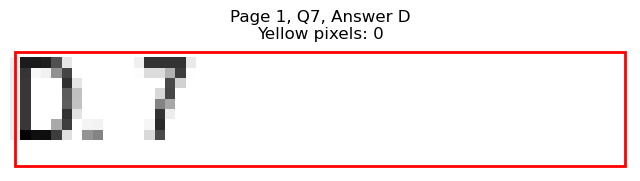


Page 1, Q7 - Selected Answer: C (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=596.0, x1=145.0, y1=607.0
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 375
Page 1, Q8, A: Yellow percentage: 0.0%


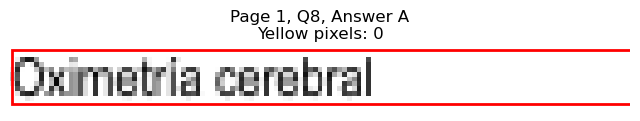

Page 1, Q8 - B: Detected box: x0=68.3, y0=608.6, x1=271.4, y1=619.6
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 1050
Page 1, Q8, B: Yellow percentage: 0.0%


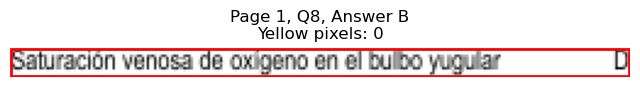

Page 1, Q8 - C: Detected box: x0=327.5, y0=596.0, x1=541.1, y1=607.0
Page 1, Q8, C: Yellow pixels: 1758
Page 1, Q8, C: Total non-white pixels: 2561
Page 1, Q8, C: Yellow percentage: 68.6%


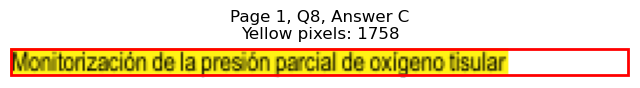

Page 1, Q8 - D: Detected box: x0=327.5, y0=608.6, x1=453.4, y1=619.6
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 666
Page 1, Q8, D: Yellow percentage: 0.0%


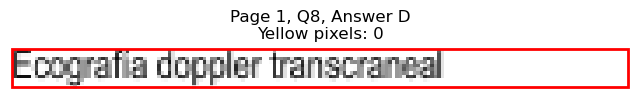


Page 1, Q8 - Selected Answer: C (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=659.1, x1=237.2, y1=670.2
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 865
Page 1, Q9, A: Yellow percentage: 0.0%


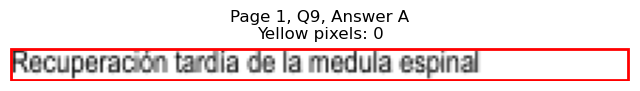

Page 1, Q9 - B: Detected box: x0=68.3, y0=671.7, x1=270.4, y1=682.8
Page 1, Q9, B: Yellow pixels: 253
Page 1, Q9, B: Total non-white pixels: 1246
Page 1, Q9, B: Yellow percentage: 20.3%


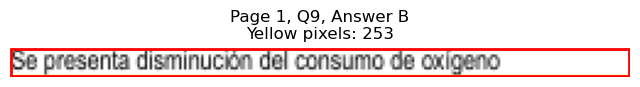

Page 1, Q9 - C: Detected box: x0=68.8, y0=684.3, x1=275.4, y1=695.4
Page 1, Q9, C: Yellow pixels: 2033
Page 1, Q9, C: Total non-white pixels: 3096
Page 1, Q9, C: Yellow percentage: 65.7%


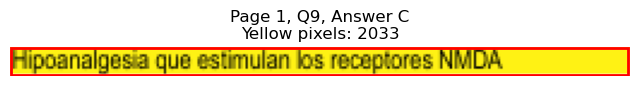

Page 1, Q9 - D: Detected box: x0=68.8, y0=697.0, x1=290.9, y1=708.1
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 1120
Page 1, Q9, D: Yellow percentage: 0.0%


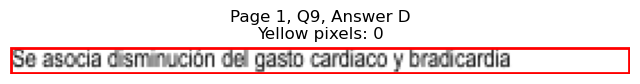


Page 1, Q9 - Selected Answer: C (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=68.3, y0=747.4, x1=247.3, y1=758.5
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 895
Page 1, Q10, A: Yellow percentage: 0.0%


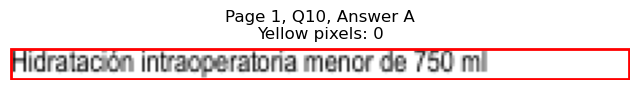

Page 1, Q10 - B: Detected box: x0=68.3, y0=760.2, x1=239.8, y1=771.2
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 877
Page 1, Q10, B: Yellow percentage: 0.0%


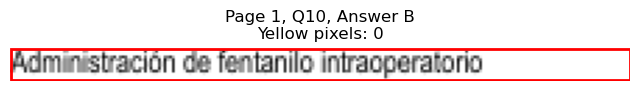

Page 1, Q10 - C: Detected box: x0=327.5, y0=747.4, x1=527.2, y1=758.5
Page 1, Q10, C: Yellow pixels: 1575
Page 1, Q10, C: Total non-white pixels: 2556
Page 1, Q10, C: Yellow percentage: 61.6%


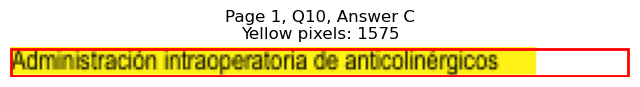

Page 1, Q10 - D: Detected box: x0=327.5, y0=760.2, x1=478.6, y1=771.2
Page 1, Q10, D: Yellow pixels: 0
Page 1, Q10, D: Total non-white pixels: 768
Page 1, Q10, D: Yellow percentage: 0.0%


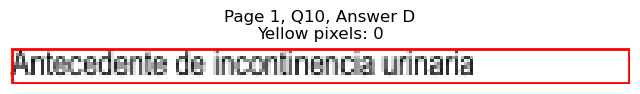


Page 1, Q10 - Selected Answer: C (based on yellow pixel count)





Page 2: Found 11 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=107.9, y1=114.8
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 179
Page 2, Q1, A: Yellow percentage: 0.0%


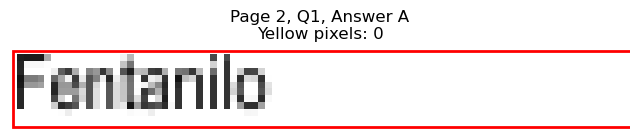

Page 2, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=121.4, y1=127.4
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 277
Page 2, Q1, B: Yellow percentage: 0.0%


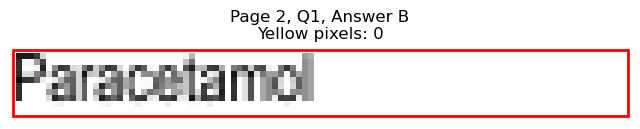

Page 2, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=368.2, y1=114.8
Page 2, Q1, C: Yellow pixels: 960
Page 2, Q1, C: Total non-white pixels: 1104
Page 2, Q1, C: Yellow percentage: 87.0%


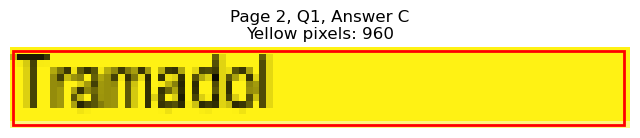

Page 2, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=360.1, y1=127.4
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 164
Page 2, Q1, D: Yellow percentage: 0.0%


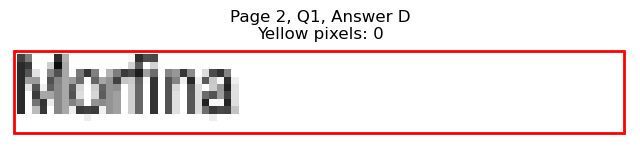


Page 2, Q1 - Selected Answer: C (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=139.4, y1=190.5
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 387
Page 2, Q2, A: Yellow percentage: 0.0%


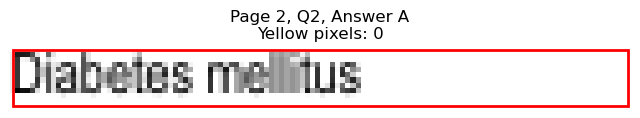

Page 2, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=151.6, y1=203.1
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 447
Page 2, Q2, B: Yellow percentage: 0.0%


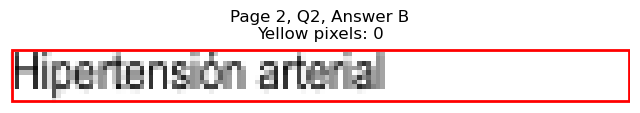

Page 2, Q2 - C: Detected box: x0=327.5, y0=179.5, x1=443.9, y1=190.5
Page 2, Q2, C: Yellow pixels: 1398
Page 2, Q2, C: Total non-white pixels: 2004
Page 2, Q2, C: Yellow percentage: 69.8%


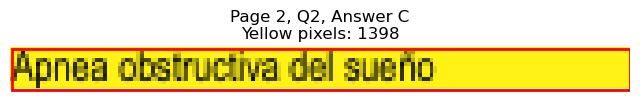

Page 2, Q2 - D: Detected box: x0=327.5, y0=192.1, x1=349.6, y1=203.1
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 111
Page 2, Q2, D: Yellow percentage: 0.0%


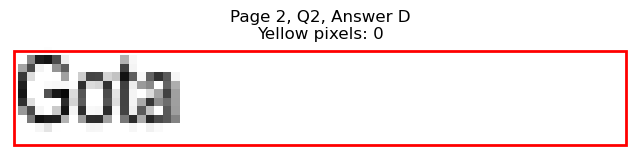


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=255.2, x1=278.0, y1=266.2
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 1060
Page 2, Q3, A: Yellow percentage: 0.0%


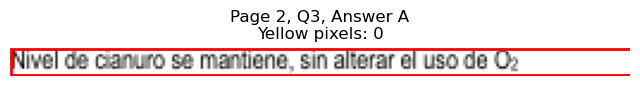

Page 2, Q3 - B: Detected box: x0=68.3, y0=267.8, x1=245.4, y1=278.8
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 901
Page 2, Q3, B: Yellow percentage: 0.0%


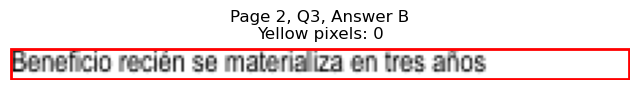

Page 2, Q3 - C: Detected box: x0=68.8, y0=280.5, x1=242.3, y1=291.6
Page 2, Q3, C: Yellow pixels: 225
Page 2, Q3, C: Total non-white pixels: 1075
Page 2, Q3, C: Yellow percentage: 20.9%


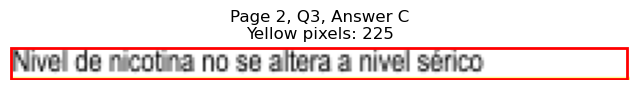

Page 2, Q3 - D: Detected box: x0=68.8, y0=293.1, x1=288.0, y1=304.2
Page 2, Q3, D: Yellow pixels: 2111
Page 2, Q3, D: Total non-white pixels: 2975
Page 2, Q3, D: Yellow percentage: 71.0%


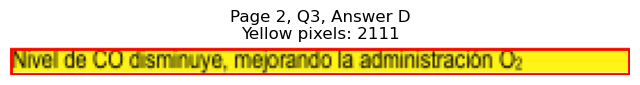


Page 2, Q3 - Selected Answer: D (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=330.9, x1=292.4, y1=342.0
Page 2, Q4, A: Yellow pixels: 2443
Page 2, Q4, A: Total non-white pixels: 3300
Page 2, Q4, A: Yellow percentage: 74.0%


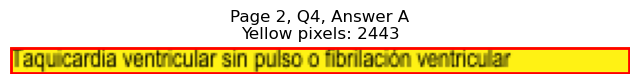

Page 2, Q4 - B: Detected box: x0=68.3, y0=343.6, x1=223.7, y1=354.7
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 806
Page 2, Q4, B: Yellow percentage: 0.0%


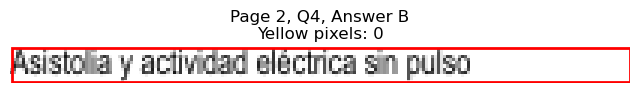

Page 2, Q4 - C: Detected box: x0=68.8, y0=356.2, x1=281.9, y1=367.3
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 1086
Page 2, Q4, C: Yellow percentage: 0.0%


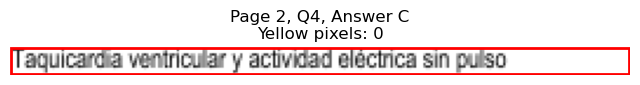

Page 2, Q4 - D: Detected box: x0=68.8, y0=368.8, x1=276.0, y1=379.9
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 1055
Page 2, Q4, D: Yellow percentage: 0.0%


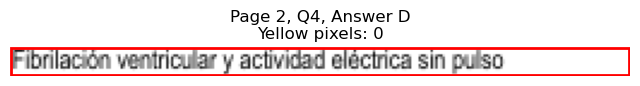


Page 2, Q4 - Selected Answer: A (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=406.6, x1=110.9, y1=417.7
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 201
Page 2, Q5, A: Yellow percentage: 0.0%


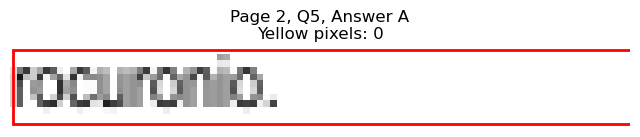

Page 2, Q5 - B: Detected box: x0=68.3, y0=419.4, x1=115.4, y1=430.4
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 246
Page 2, Q5, B: Yellow percentage: 0.0%


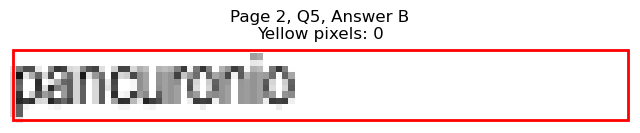

Page 2, Q5 - C: Detected box: x0=327.5, y0=406.6, x1=368.6, y1=417.7
Page 2, Q5, C: Yellow pixels: 92
Page 2, Q5, C: Total non-white pixels: 293
Page 2, Q5, C: Yellow percentage: 31.4%


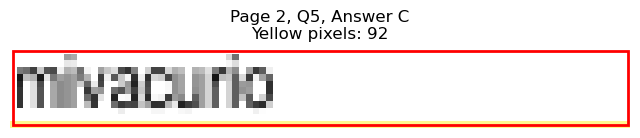

Page 2, Q5 - D: Detected box: x0=327.5, y0=419.4, x1=365.0, y1=430.4
Page 2, Q5, D: Yellow pixels: 842
Page 2, Q5, D: Total non-white pixels: 1068
Page 2, Q5, D: Yellow percentage: 78.8%


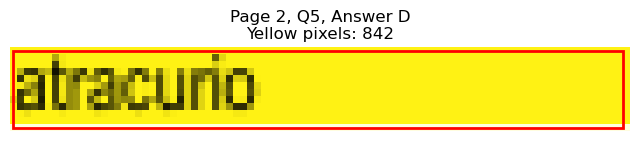


Page 2, Q5 - Selected Answer: D (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=469.8, x1=107.4, y1=480.8
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 176
Page 2, Q6, A: Yellow percentage: 0.0%


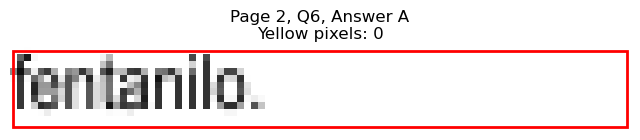

Page 2, Q6 - B: Detected box: x0=68.3, y0=482.5, x1=117.0, y1=493.5
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 251
Page 2, Q6, B: Yellow percentage: 0.0%


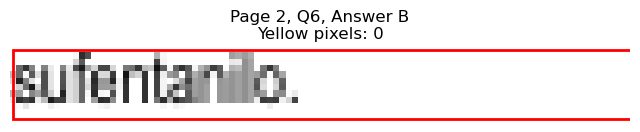

Page 2, Q6 - C: Detected box: x0=327.5, y0=469.8, x1=362.6, y1=480.8
Page 2, Q6, C: Yellow pixels: 909
Page 2, Q6, C: Total non-white pixels: 1032
Page 2, Q6, C: Yellow percentage: 88.1%


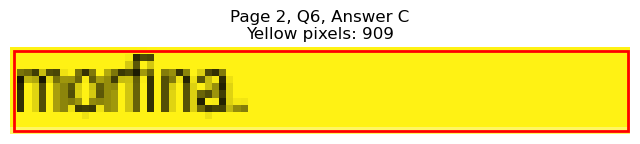

Page 2, Q6 - D: Detected box: x0=327.5, y0=482.5, x1=369.1, y1=493.5
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 200
Page 2, Q6, D: Yellow percentage: 0.0%


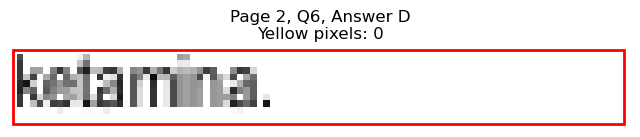


Page 2, Q6 - Selected Answer: C (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=520.3, x1=109.9, y1=531.3
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 203
Page 2, Q7, A: Yellow percentage: 0.0%


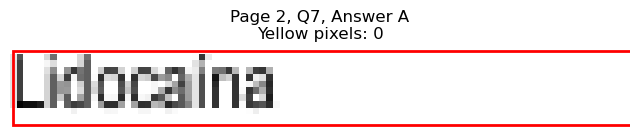

Page 2, Q7 - B: Detected box: x0=68.3, y0=532.9, x1=109.9, y1=543.9
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 237
Page 2, Q7, B: Yellow percentage: 0.0%


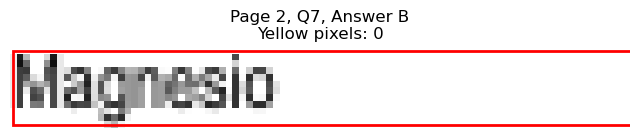

Page 2, Q7 - C: Detected box: x0=327.5, y0=520.3, x1=372.6, y1=531.3
Page 2, Q7, C: Yellow pixels: 891
Page 2, Q7, C: Total non-white pixels: 1152
Page 2, Q7, C: Yellow percentage: 77.3%


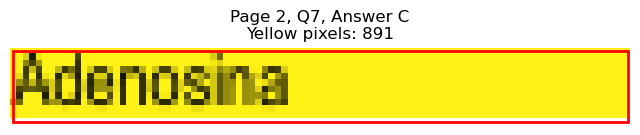

Page 2, Q7 - D: Detected box: x0=327.5, y0=532.9, x1=357.7, y1=543.9
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 167
Page 2, Q7, D: Yellow percentage: 0.0%


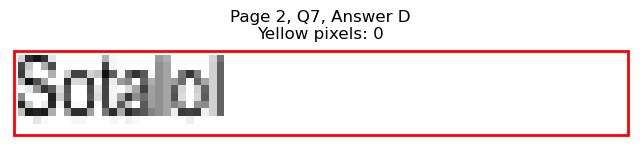


Page 2, Q7 - Selected Answer: C (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=583.4, x1=108.4, y1=594.4
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 209
Page 2, Q8, A: Yellow percentage: 0.0%


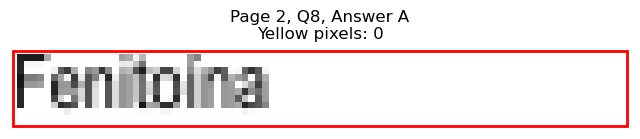

Page 2, Q8 - B: Detected box: x0=68.3, y0=596.0, x1=109.9, y1=607.0
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 203
Page 2, Q8, B: Yellow percentage: 0.0%


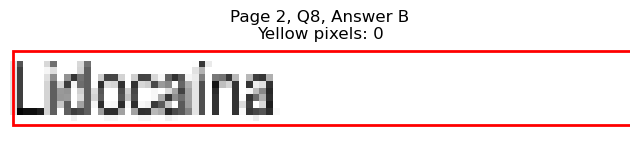

Page 2, Q8 - C: Detected box: x0=327.5, y0=583.4, x1=378.6, y1=594.4
Page 2, Q8, C: Yellow pixels: 924
Page 2, Q8, C: Total non-white pixels: 1224
Page 2, Q8, C: Yellow percentage: 75.5%


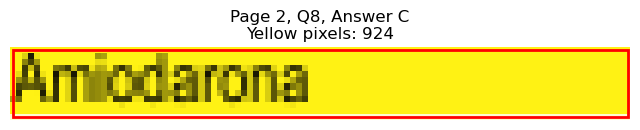

Page 2, Q8 - D: Detected box: x0=327.5, y0=596.0, x1=370.6, y1=607.0
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 238
Page 2, Q8, D: Yellow percentage: 0.0%


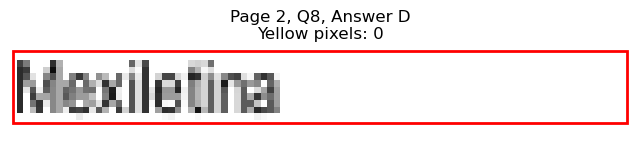


Page 2, Q8 - Selected Answer: C (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=633.9, x1=146.6, y1=645.0
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 537
Page 2, Q9, A: Yellow percentage: 0.0%


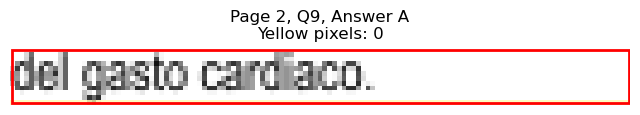

Page 2, Q9 - B: Detected box: x0=68.3, y0=646.5, x1=186.2, y1=657.6
Page 2, Q9, B: Yellow pixels: 1406
Page 2, Q9, B: Total non-white pixels: 2028
Page 2, Q9, B: Yellow percentage: 69.3%


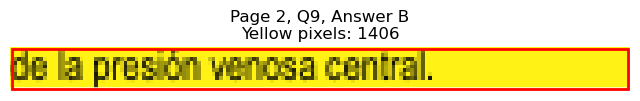

Page 2, Q9 - C: Detected box: x0=327.5, y0=633.9, x1=436.9, y1=645.0
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 534
Page 2, Q9, C: Yellow percentage: 0.0%


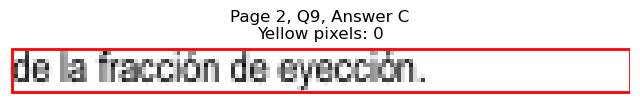

Page 2, Q9 - D: Detected box: x0=327.5, y0=646.5, x1=430.9, y1=657.6
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 513
Page 2, Q9, D: Yellow percentage: 0.0%


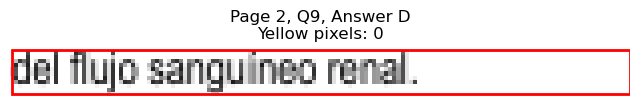


Page 2, Q9 - Selected Answer: B (based on yellow pixel count)




Page 2, Q10 - A: Detected box: x0=68.3, y0=684.3, x1=104.4, y1=695.4
Page 2, Q10, A: Yellow pixels: 807
Page 2, Q10, A: Total non-white pixels: 1044
Page 2, Q10, A: Yellow percentage: 77.3%


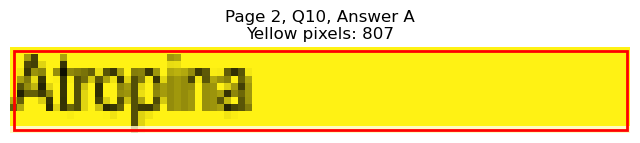

Page 2, Q10 - B: Detected box: x0=68.3, y0=697.0, x1=112.0, y1=708.1
Page 2, Q10, B: Yellow pixels: 0
Page 2, Q10, B: Total non-white pixels: 232
Page 2, Q10, B: Yellow percentage: 0.0%


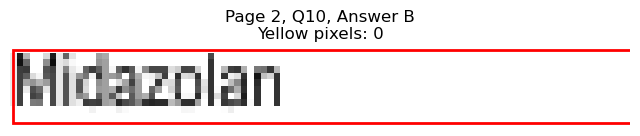

Page 2, Q10 - C: Detected box: x0=327.5, y0=684.3, x1=367.1, y1=695.4
Page 2, Q10, C: Yellow pixels: 0
Page 2, Q10, C: Total non-white pixels: 199
Page 2, Q10, C: Yellow percentage: 0.0%


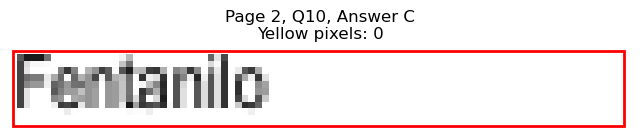

Page 2, Q10 - D: Detected box: x0=327.5, y0=697.0, x1=380.2, y1=708.1
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 296
Page 2, Q10, D: Yellow percentage: 0.0%


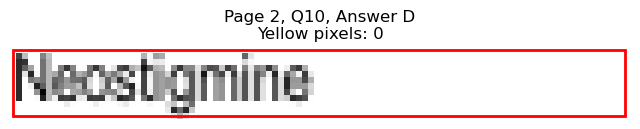


Page 2, Q10 - Selected Answer: A (based on yellow pixel count)




Page 2, Q11 - A: Detected box: x0=68.3, y0=747.4, x1=84.4, y1=758.5
Page 2, Q11, A: Yellow pixels: 67
Page 2, Q11, A: Total non-white pixels: 149
Page 2, Q11, A: Yellow percentage: 45.0%


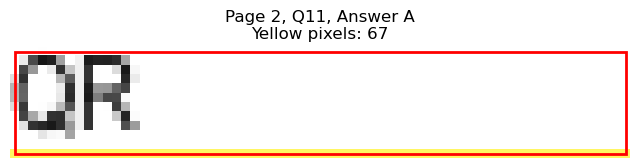

Page 2, Q11 - B: Detected box: x0=68.3, y0=760.2, x1=82.3, y1=771.2
Page 2, Q11, B: Yellow pixels: 670
Page 2, Q11, B: Total non-white pixels: 715
Page 2, Q11, B: Yellow percentage: 93.7%


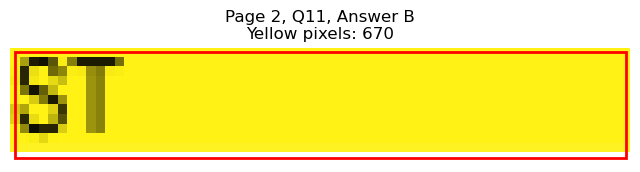

Page 2, Q11 - C: Detected box: x0=327.5, y0=747.4, x1=343.1, y1=758.5
Page 2, Q11, C: Yellow pixels: 0
Page 2, Q11, C: Total non-white pixels: 74
Page 2, Q11, C: Yellow percentage: 0.0%


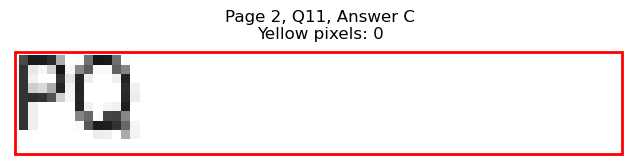

Page 2, Q11 - D: Detected box: x0=327.5, y0=760.2, x1=342.5, y1=771.2
Page 2, Q11, D: Yellow pixels: 0
Page 2, Q11, D: Total non-white pixels: 76
Page 2, Q11, D: Yellow percentage: 0.0%


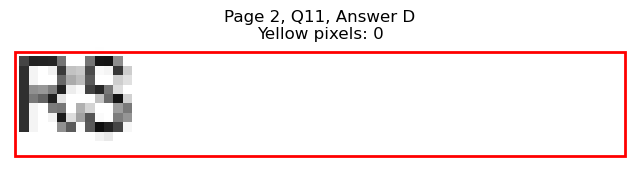


Page 2, Q11 - Selected Answer: B (based on yellow pixel count)





Page 3: Found 11 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=163.6, y1=114.8
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 478
Page 3, Q1, A: Yellow percentage: 0.0%


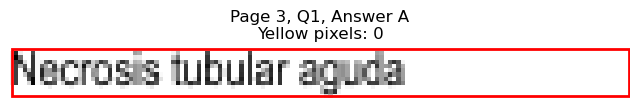

Page 3, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=109.9, y1=127.4
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 212
Page 3, Q1, B: Yellow percentage: 0.0%


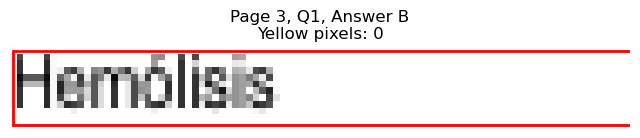

Page 3, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=477.4, y1=114.8
Page 3, Q1, C: Yellow pixels: 1840
Page 3, Q1, C: Total non-white pixels: 2412
Page 3, Q1, C: Yellow percentage: 76.3%


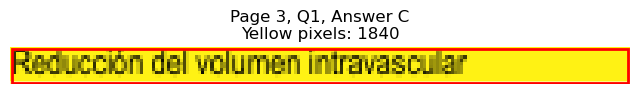

Page 3, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=409.2, y1=127.4
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 426
Page 3, Q1, D: Yellow percentage: 0.0%


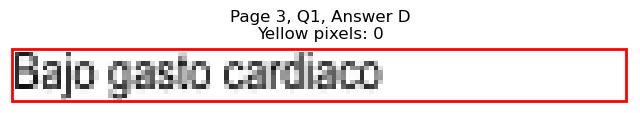


Page 3, Q1 - Selected Answer: C (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=154.3, x1=115.9, y1=165.3
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 231
Page 3, Q2, A: Yellow percentage: 0.0%


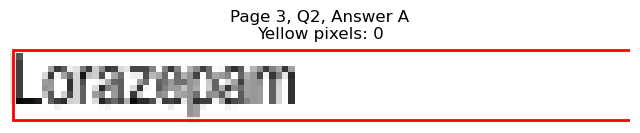

Page 3, Q2 - B: Detected box: x0=68.3, y0=166.9, x1=128.4, y1=177.9
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 299
Page 3, Q2, B: Yellow percentage: 0.0%


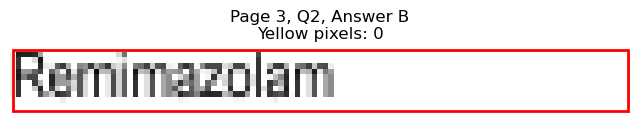

Page 3, Q2 - C: Detected box: x0=327.5, y0=154.3, x1=373.6, y1=165.3
Page 3, Q2, C: Yellow pixels: 97
Page 3, Q2, C: Total non-white pixels: 347
Page 3, Q2, C: Yellow percentage: 28.0%


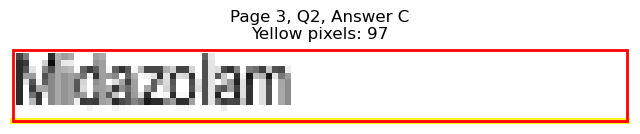

Page 3, Q2 - D: Detected box: x0=327.5, y0=166.9, x1=370.6, y1=177.9
Page 3, Q2, D: Yellow pixels: 958
Page 3, Q2, D: Total non-white pixels: 1128
Page 3, Q2, D: Yellow percentage: 84.9%


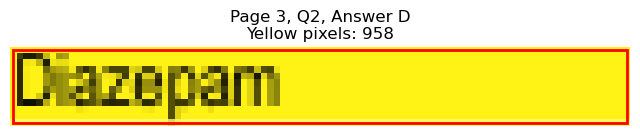


Page 3, Q2 - Selected Answer: D (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=217.4, x1=180.6, y1=228.4
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 574
Page 3, Q3, A: Yellow percentage: 0.0%


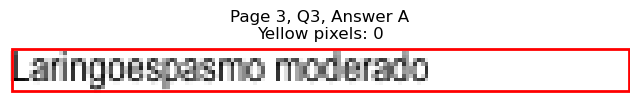

Page 3, Q3 - B: Detected box: x0=68.3, y0=230.0, x1=129.5, y1=241.0
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 317
Page 3, Q3, B: Yellow percentage: 0.0%


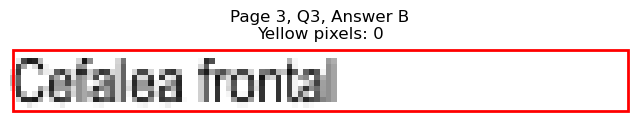

Page 3, Q3 - C: Detected box: x0=327.5, y0=217.4, x1=459.5, y1=228.4
Page 3, Q3, C: Yellow pixels: 1508
Page 3, Q3, C: Total non-white pixels: 2196
Page 3, Q3, C: Yellow percentage: 68.7%


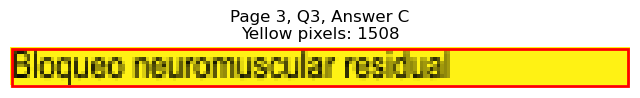

Page 3, Q3 - D: Detected box: x0=327.5, y0=230.0, x1=408.7, y1=241.0
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 419
Page 3, Q3, D: Yellow percentage: 0.0%


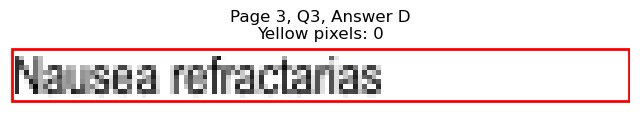


Page 3, Q3 - Selected Answer: C (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=280.5, x1=192.2, y1=291.6
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 653
Page 3, Q4, A: Yellow percentage: 0.0%


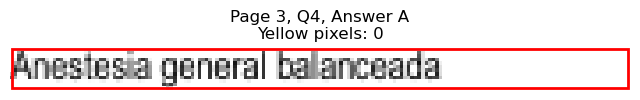

Page 3, Q4 - B: Detected box: x0=68.3, y0=293.1, x1=90.8, y1=304.2
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 98
Page 3, Q4, B: Yellow percentage: 0.0%


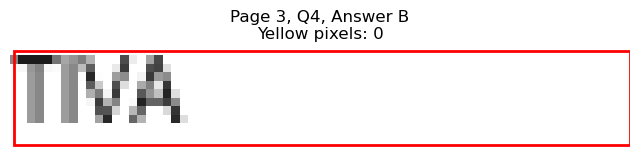

Page 3, Q4 - C: Detected box: x0=327.5, y0=280.5, x1=389.6, y1=291.6
Page 3, Q4, C: Yellow pixels: 113
Page 3, Q4, C: Total non-white pixels: 454
Page 3, Q4, C: Yellow percentage: 24.9%


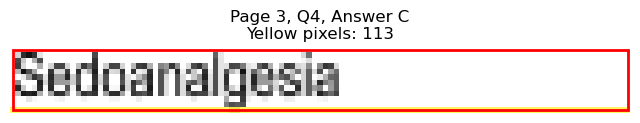

Page 3, Q4 - D: Detected box: x0=327.5, y0=293.1, x1=404.3, y1=304.2
Page 3, Q4, D: Yellow pixels: 1115
Page 3, Q4, D: Total non-white pixels: 1410
Page 3, Q4, D: Yellow percentage: 79.1%


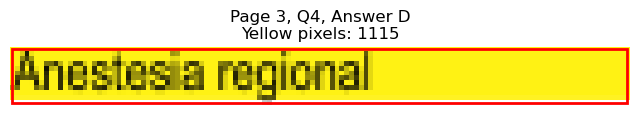


Page 3, Q4 - Selected Answer: D (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=343.6, x1=121.0, y1=354.7
Page 3, Q5, A: Yellow pixels: 1004
Page 3, Q5, A: Total non-white pixels: 1236
Page 3, Q5, A: Yellow percentage: 81.2%


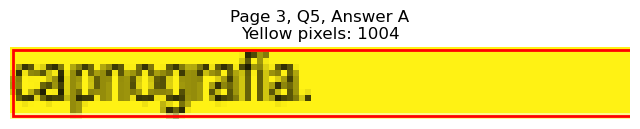

Page 3, Q5 - B: Detected box: x0=68.3, y0=356.2, x1=129.0, y1=367.3
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 310
Page 3, Q5, B: Yellow percentage: 0.0%


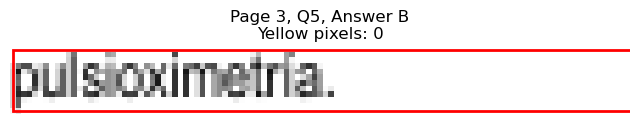

Page 3, Q5 - C: Detected box: x0=327.5, y0=343.6, x1=397.2, y1=354.7
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 354
Page 3, Q5, C: Yellow percentage: 0.0%


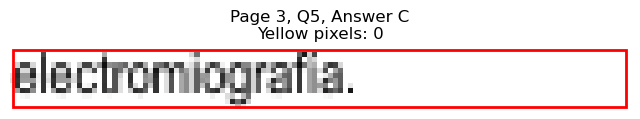

Page 3, Q5 - D: Detected box: x0=327.5, y0=356.2, x1=377.6, y1=367.3
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 253
Page 3, Q5, D: Yellow percentage: 0.0%


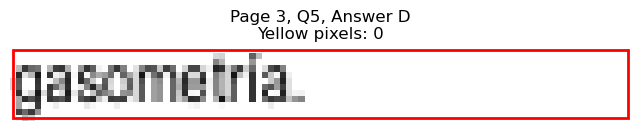


Page 3, Q5 - Selected Answer: A (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=406.6, x1=130.0, y1=417.7
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 278
Page 3, Q6, A: Yellow percentage: 0.0%


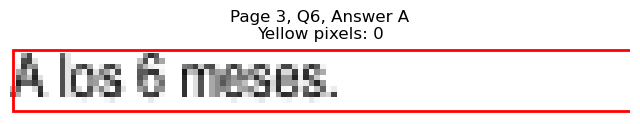

Page 3, Q6 - B: Detected box: x0=68.3, y0=419.4, x1=167.2, y1=430.4
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 495
Page 3, Q6, B: Yellow percentage: 0.0%


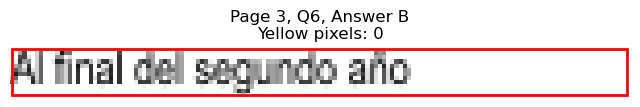

Page 3, Q6 - C: Detected box: x0=327.5, y0=406.6, x1=448.8, y1=417.7
Page 3, Q6, C: Yellow pixels: 1636
Page 3, Q6, C: Total non-white pixels: 2064
Page 3, Q6, C: Yellow percentage: 79.3%


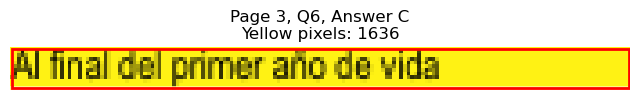

Page 3, Q6 - D: Detected box: x0=327.5, y0=419.4, x1=465.0, y1=430.4
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 618
Page 3, Q6, D: Yellow percentage: 0.0%


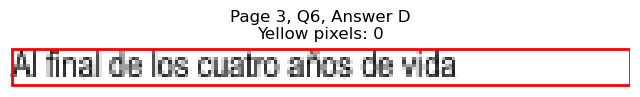


Page 3, Q6 - Selected Answer: C (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=482.5, x1=134.5, y1=493.5
Page 3, Q7, A: Yellow pixels: 117
Page 3, Q7, A: Total non-white pixels: 458
Page 3, Q7, A: Yellow percentage: 25.5%


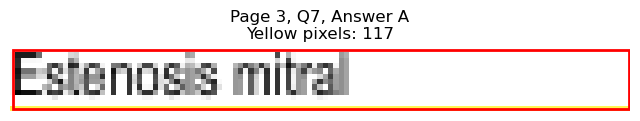

Page 3, Q7 - B: Detected box: x0=68.3, y0=495.1, x1=139.6, y1=506.1
Page 3, Q7, B: Yellow pixels: 1056
Page 3, Q7, B: Total non-white pixels: 1342
Page 3, Q7, B: Yellow percentage: 78.7%


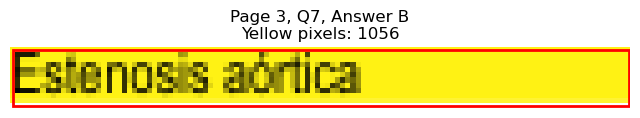

Page 3, Q7 - C: Detected box: x0=327.5, y0=482.5, x1=404.2, y1=493.5
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 394
Page 3, Q7, C: Yellow percentage: 0.0%


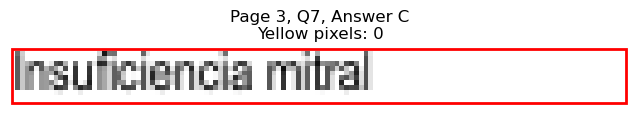

Page 3, Q7 - D: Detected box: x0=327.5, y0=495.1, x1=442.8, y1=506.1
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 567
Page 3, Q7, D: Yellow percentage: 0.0%


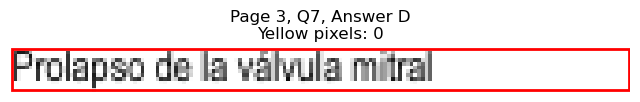


Page 3, Q7 - Selected Answer: B (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=545.5, x1=182.3, y1=556.5
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 592
Page 3, Q8, A: Yellow percentage: 0.0%


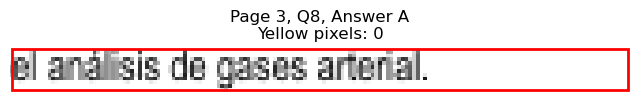

Page 3, Q8 - B: Detected box: x0=68.3, y0=558.2, x1=133.1, y1=569.2
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 309
Page 3, Q8, B: Yellow percentage: 0.0%


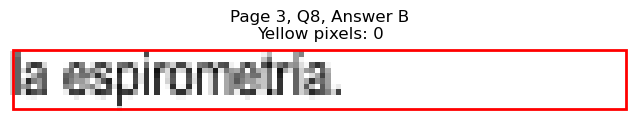

Page 3, Q8 - C: Detected box: x0=327.5, y0=545.5, x1=419.9, y1=556.5
Page 3, Q8, C: Yellow pixels: 143
Page 3, Q8, C: Total non-white pixels: 587
Page 3, Q8, C: Yellow percentage: 24.4%


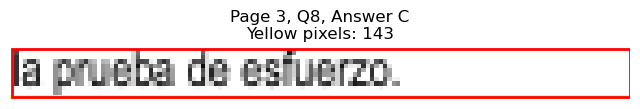

Page 3, Q8 - D: Detected box: x0=327.5, y0=558.2, x1=385.3, y1=569.2
Page 3, Q8, D: Yellow pixels: 980
Page 3, Q8, D: Total non-white pixels: 1199
Page 3, Q8, D: Yellow percentage: 81.7%


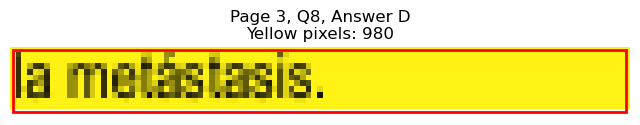


Page 3, Q8 - Selected Answer: D (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=68.3, y0=608.6, x1=163.6, y1=619.6
Page 3, Q9, A: Yellow pixels: 1391
Page 3, Q9, A: Total non-white pixels: 1752
Page 3, Q9, A: Yellow percentage: 79.4%


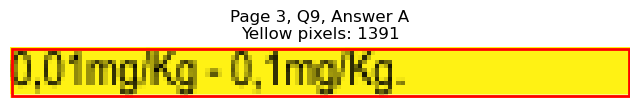

Page 3, Q9 - B: Detected box: x0=68.3, y0=621.3, x1=158.5, y1=632.4
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 447
Page 3, Q9, B: Yellow percentage: 0.0%


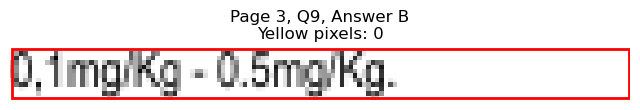

Page 3, Q9 - C: Detected box: x0=327.5, y0=608.6, x1=417.7, y1=619.6
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 444
Page 3, Q9, C: Yellow percentage: 0.0%


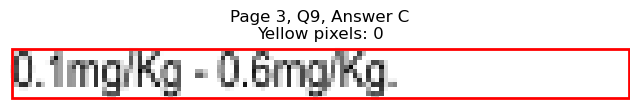

Page 3, Q9 - D: Detected box: x0=327.5, y0=621.3, x1=422.8, y1=632.4
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 477
Page 3, Q9, D: Yellow percentage: 0.0%


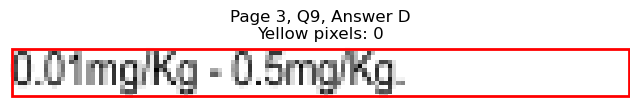


Page 3, Q9 - Selected Answer: A (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=68.3, y0=671.7, x1=126.5, y1=682.8
Page 3, Q10, A: Yellow pixels: 1083
Page 3, Q10, A: Total non-white pixels: 1308
Page 3, Q10, A: Yellow percentage: 82.8%


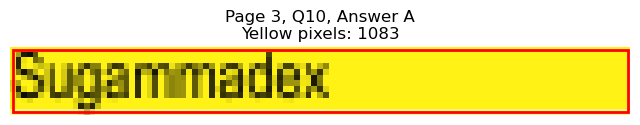

Page 3, Q10 - B: Detected box: x0=68.3, y0=684.3, x1=121.0, y1=695.4
Page 3, Q10, B: Yellow pixels: 0
Page 3, Q10, B: Total non-white pixels: 278
Page 3, Q10, B: Yellow percentage: 0.0%


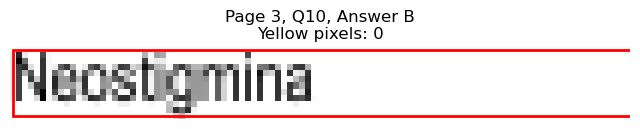

Page 3, Q10 - C: Detected box: x0=327.5, y0=671.7, x1=386.6, y1=682.8
Page 3, Q10, C: Yellow pixels: 0
Page 3, Q10, C: Total non-white pixels: 295
Page 3, Q10, C: Yellow percentage: 0.0%


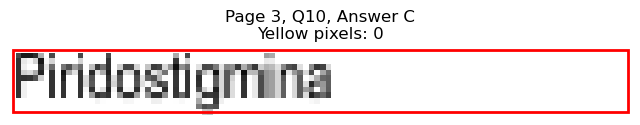

Page 3, Q10 - D: Detected box: x0=327.5, y0=684.3, x1=368.8, y1=695.4
Page 3, Q10, D: Yellow pixels: 0
Page 3, Q10, D: Total non-white pixels: 207
Page 3, Q10, D: Yellow percentage: 0.0%


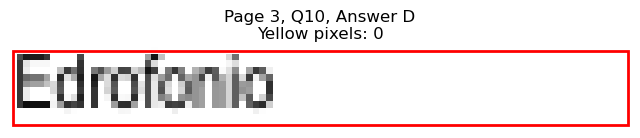


Page 3, Q10 - Selected Answer: A (based on yellow pixel count)




Page 3, Q11 - A: Detected box: x0=68.3, y0=734.8, x1=160.1, y1=745.9
Page 3, Q11, A: Yellow pixels: 0
Page 3, Q11, A: Total non-white pixels: 593
Page 3, Q11, A: Yellow percentage: 0.0%


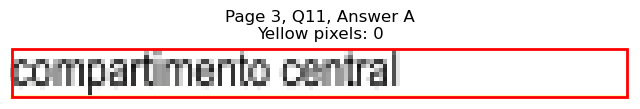

Page 3, Q11 - B: Detected box: x0=68.3, y0=747.4, x1=99.8, y1=758.5
Page 3, Q11, B: Yellow pixels: 783
Page 3, Q11, B: Total non-white pixels: 984
Page 3, Q11, B: Yellow percentage: 79.6%


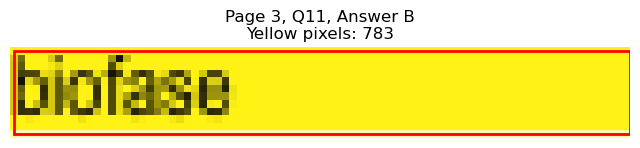

Page 3, Q11 - C: Detected box: x0=327.5, y0=734.8, x1=368.2, y1=745.9
Page 3, Q11, C: Yellow pixels: 0
Page 3, Q11, C: Total non-white pixels: 207
Page 3, Q11, C: Yellow percentage: 0.0%


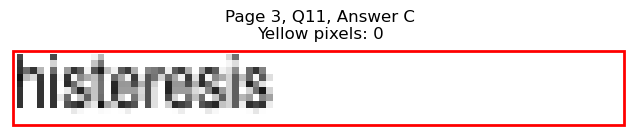

Page 3, Q11 - D: Detected box: x0=327.5, y0=747.4, x1=431.3, y1=758.5
Page 3, Q11, D: Yellow pixels: 0
Page 3, Q11, D: Total non-white pixels: 561
Page 3, Q11, D: Yellow percentage: 0.0%


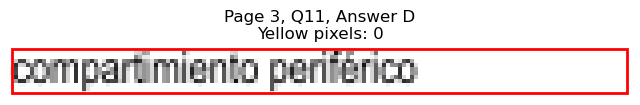


Page 3, Q11 - Selected Answer: B (based on yellow pixel count)





Page 4: Found 11 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=218.2, y1=102.2
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 759
Page 4, Q1, A: Yellow percentage: 0.0%


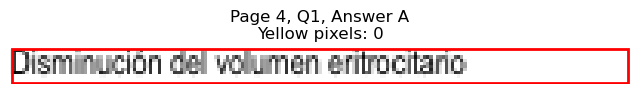

Page 4, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=195.7, y1=114.8
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 652
Page 4, Q1, B: Yellow percentage: 0.0%


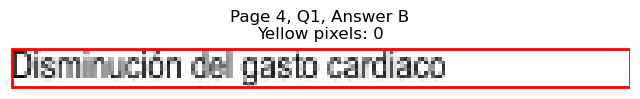

Page 4, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=510.1, y1=102.2
Page 4, Q1, C: Yellow pixels: 213
Page 4, Q1, C: Total non-white pixels: 1310
Page 4, Q1, C: Yellow percentage: 16.3%


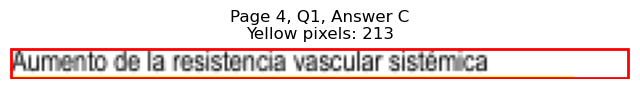

Page 4, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=462.8, y1=114.8
Page 4, Q1, D: Yellow pixels: 1721
Page 4, Q1, D: Total non-white pixels: 2232
Page 4, Q1, D: Yellow percentage: 77.1%


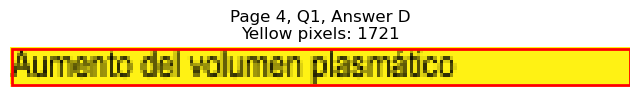


Page 4, Q1 - Selected Answer: D (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=56.6, y0=166.9, x1=65.2, y1=177.9
Page 4, Q2, A: Yellow pixels: 668
Page 4, Q2, A: Total non-white pixels: 720
Page 4, Q2, A: Yellow percentage: 92.8%


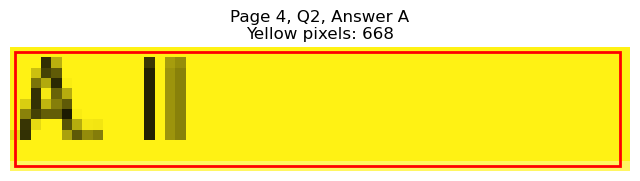

Page 4, Q2 - B: Detected box: x0=68.3, y0=495.1, x1=78.4, y1=506.1
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 32
Page 4, Q2, B: Yellow percentage: 0.0%


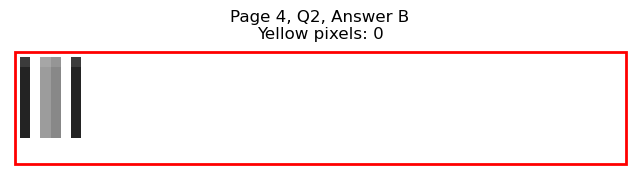

Page 4, Q2 - C: Detected box: x0=327.5, y0=166.9, x1=338.5, y1=177.9
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 43
Page 4, Q2, C: Yellow percentage: 0.0%


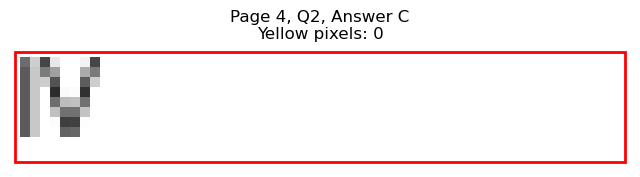

Page 4, Q2 - D: Detected box: x0=315.4, y0=179.5, x1=324.4, y1=190.5
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 71
Page 4, Q2, D: Yellow percentage: 0.0%


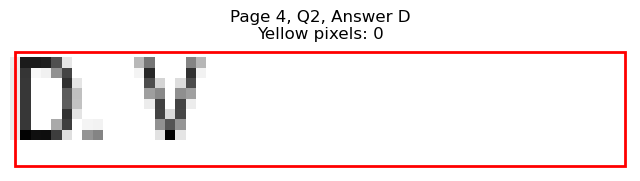


Page 4, Q2 - Selected Answer: A (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=217.4, x1=209.6, y1=228.4
Page 4, Q3, A: Yellow pixels: 1569
Page 4, Q3, A: Total non-white pixels: 2304
Page 4, Q3, A: Yellow percentage: 68.1%


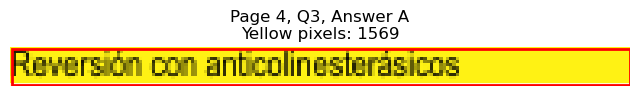

Page 4, Q3 - B: Detected box: x0=68.3, y0=230.0, x1=181.6, y1=241.0
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 579
Page 4, Q3, B: Yellow percentage: 0.0%


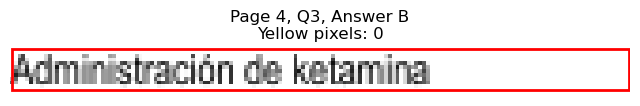

Page 4, Q3 - C: Detected box: x0=327.5, y0=217.4, x1=441.8, y1=228.4
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 592
Page 4, Q3, C: Yellow percentage: 0.0%


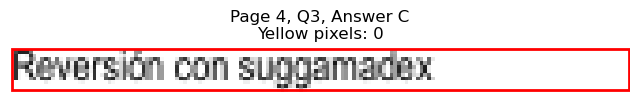

Page 4, Q3 - D: Detected box: x0=327.5, y0=230.0, x1=415.3, y1=241.0
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 454
Page 4, Q3, D: Yellow percentage: 0.0%


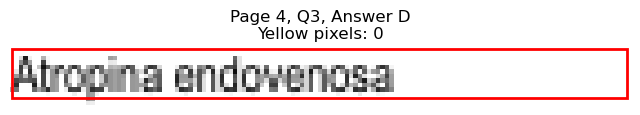


Page 4, Q3 - Selected Answer: A (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=293.1, x1=169.6, y1=304.2
Page 4, Q4, A: Yellow pixels: 152
Page 4, Q4, A: Total non-white pixels: 788
Page 4, Q4, A: Yellow percentage: 19.3%


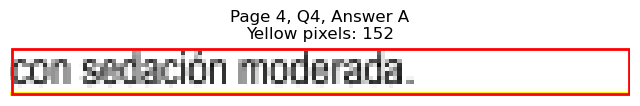

Page 4, Q4 - B: Detected box: x0=68.3, y0=305.7, x1=189.1, y1=316.8
Page 4, Q4, B: Yellow pixels: 1585
Page 4, Q4, B: Total non-white pixels: 2064
Page 4, Q4, B: Yellow percentage: 76.8%


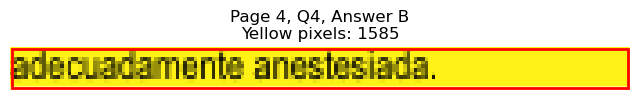

Page 4, Q4 - C: Detected box: x0=327.5, y0=293.1, x1=367.1, y1=304.2
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 158
Page 4, Q4, C: Yellow percentage: 0.0%


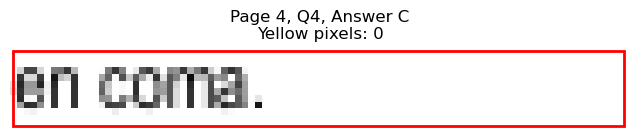

Page 4, Q4 - D: Detected box: x0=327.5, y0=305.7, x1=391.2, y1=316.8
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 325
Page 4, Q4, D: Yellow percentage: 0.0%


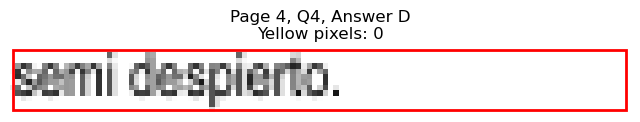


Page 4, Q4 - Selected Answer: B (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=356.2, x1=100.9, y1=367.3
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 161
Page 4, Q5, A: Yellow percentage: 0.0%


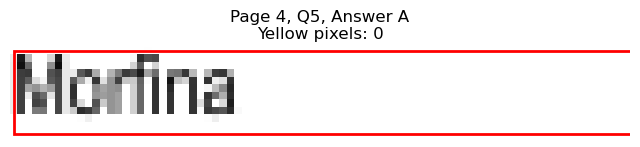

Page 4, Q5 - B: Detected box: x0=68.3, y0=368.8, x1=107.9, y1=379.9
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 179
Page 4, Q5, B: Yellow percentage: 0.0%


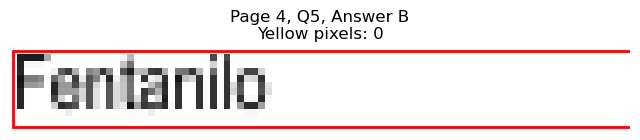

Page 4, Q5 - C: Detected box: x0=327.5, y0=356.2, x1=374.6, y1=367.3
Page 4, Q5, C: Yellow pixels: 871
Page 4, Q5, C: Total non-white pixels: 1176
Page 4, Q5, C: Yellow percentage: 74.1%


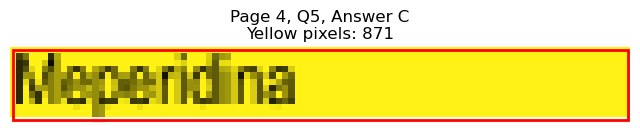

Page 4, Q5 - D: Detected box: x0=327.5, y0=368.8, x1=368.2, y1=379.9
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 215
Page 4, Q5, D: Yellow percentage: 0.0%


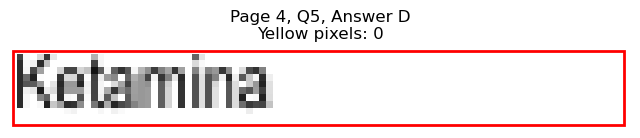


Page 4, Q5 - Selected Answer: C (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=419.4, x1=106.9, y1=430.4
Page 4, Q6, A: Yellow pixels: 89
Page 4, Q6, A: Total non-white pixels: 260
Page 4, Q6, A: Yellow percentage: 34.2%


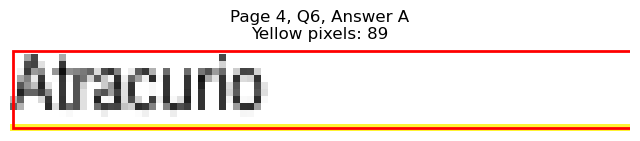

Page 4, Q6 - B: Detected box: x0=68.3, y0=432.0, x1=125.4, y1=443.0
Page 4, Q6, B: Yellow pixels: 1067
Page 4, Q6, B: Total non-white pixels: 1296
Page 4, Q6, B: Yellow percentage: 82.3%


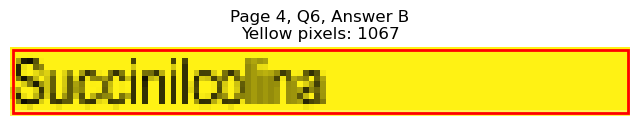

Page 4, Q6 - C: Detected box: x0=327.5, y0=419.4, x1=370.6, y1=430.4
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 218
Page 4, Q6, C: Yellow percentage: 0.0%


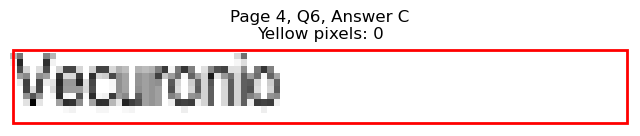

Page 4, Q6 - D: Detected box: x0=327.5, y0=432.0, x1=371.2, y1=443.0
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 207
Page 4, Q6, D: Yellow percentage: 0.0%


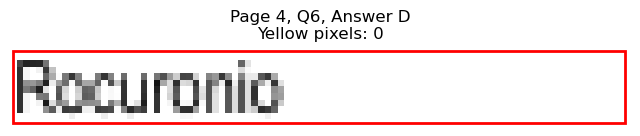


Page 4, Q6 - Selected Answer: B (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=56.6, y0=166.9, x1=65.2, y1=177.9
Page 4, Q7, A: Yellow pixels: 668
Page 4, Q7, A: Total non-white pixels: 720
Page 4, Q7, A: Yellow percentage: 92.8%


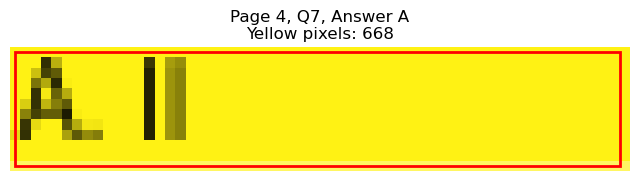

Page 4, Q7 - B: Detected box: x0=68.3, y0=495.1, x1=78.4, y1=506.1
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 32
Page 4, Q7, B: Yellow percentage: 0.0%


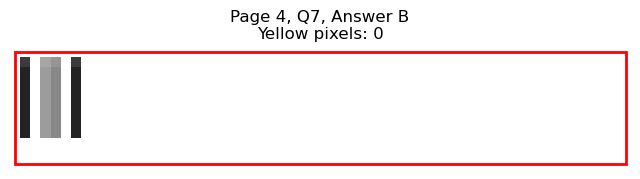

Page 4, Q7 - C: Detected box: x0=315.4, y0=482.5, x1=324.4, y1=493.5
Page 4, Q7, C: Yellow pixels: 619
Page 4, Q7, C: Total non-white pixels: 720
Page 4, Q7, C: Yellow percentage: 86.0%


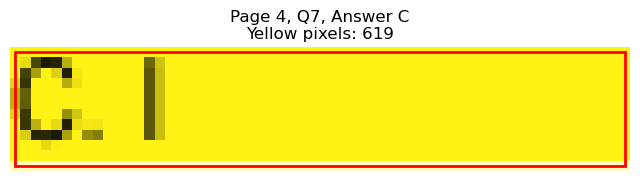

Page 4, Q7 - D: Detected box: x0=327.5, y0=495.1, x1=338.5, y1=506.1
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 43
Page 4, Q7, D: Yellow percentage: 0.0%


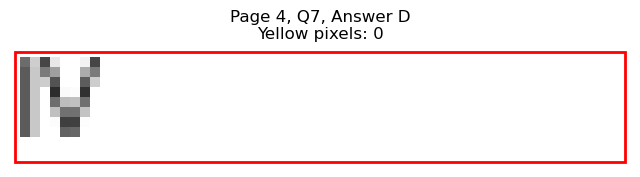


Page 4, Q7 - Selected Answer: A (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=532.9, x1=107.9, y1=543.9
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 179
Page 4, Q8, A: Yellow percentage: 0.0%


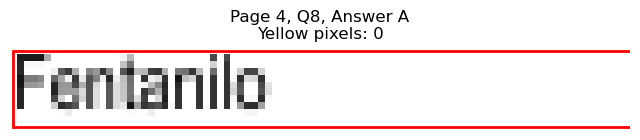

Page 4, Q8 - B: Detected box: x0=68.3, y0=545.5, x1=100.9, y1=556.5
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 161
Page 4, Q8, B: Yellow percentage: 0.0%


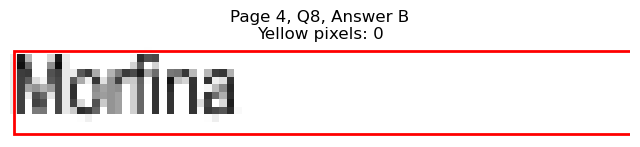

Page 4, Q8 - C: Detected box: x0=327.5, y0=532.9, x1=368.2, y1=543.9
Page 4, Q8, C: Yellow pixels: 956
Page 4, Q8, C: Total non-white pixels: 1104
Page 4, Q8, C: Yellow percentage: 86.6%


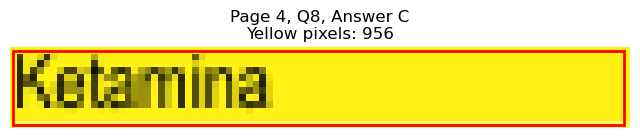

Page 4, Q8 - D: Detected box: x0=327.5, y0=545.5, x1=364.1, y1=556.5
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 179
Page 4, Q8, D: Yellow percentage: 0.0%


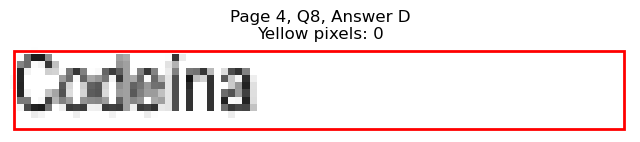


Page 4, Q8 - Selected Answer: C (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=596.0, x1=260.4, y1=607.0
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 980
Page 4, Q9, A: Yellow percentage: 0.0%


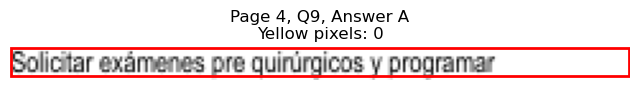

Page 4, Q9 - B: Detected box: x0=68.3, y0=608.6, x1=164.5, y1=619.6
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 461
Page 4, Q9, B: Yellow percentage: 0.0%


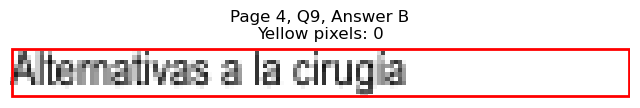

Page 4, Q9 - C: Detected box: x0=327.5, y0=596.0, x1=488.0, y1=607.0
Page 4, Q9, C: Yellow pixels: 212
Page 4, Q9, C: Total non-white pixels: 1230
Page 4, Q9, C: Yellow percentage: 17.2%


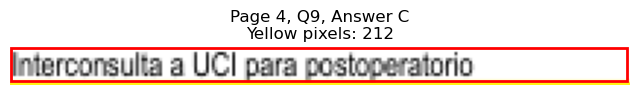

Page 4, Q9 - D: Detected box: x0=327.5, y0=608.6, x1=507.1, y1=619.6
Page 4, Q9, D: Yellow pixels: 1857
Page 4, Q9, D: Total non-white pixels: 2556
Page 4, Q9, D: Yellow percentage: 72.7%


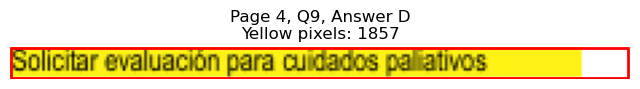


Page 4, Q9 - Selected Answer: D (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=68.3, y0=646.5, x1=120.5, y1=657.6
Page 4, Q10, A: Yellow pixels: 103
Page 4, Q10, A: Total non-white pixels: 388
Page 4, Q10, A: Yellow percentage: 26.5%


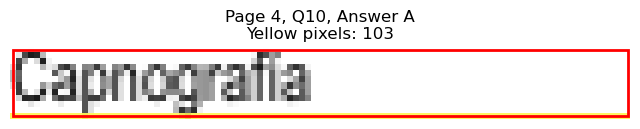

Page 4, Q10 - B: Detected box: x0=68.3, y0=659.1, x1=127.4, y1=670.2
Page 4, Q10, B: Yellow pixels: 965
Page 4, Q10, B: Total non-white pixels: 1210
Page 4, Q10, B: Yellow percentage: 79.8%


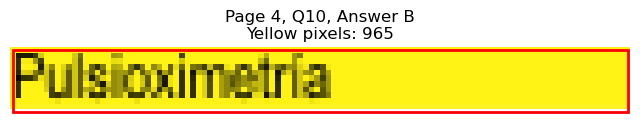

Page 4, Q10 - C: Detected box: x0=327.5, y0=646.5, x1=378.7, y1=657.6
Page 4, Q10, C: Yellow pixels: 0
Page 4, Q10, C: Total non-white pixels: 260
Page 4, Q10, C: Yellow percentage: 0.0%


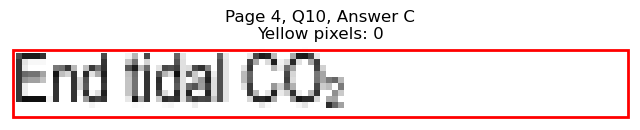

Page 4, Q10 - D: Detected box: x0=327.5, y0=659.1, x1=349.1, y1=670.2
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 98
Page 4, Q10, D: Yellow percentage: 0.0%


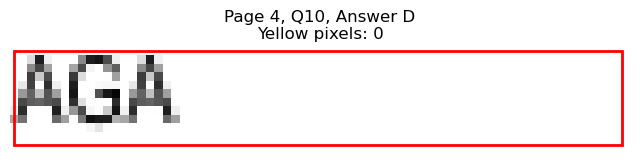


Page 4, Q10 - Selected Answer: B (based on yellow pixel count)




Page 4, Q11 - A: Detected box: x0=68.3, y0=697.0, x1=114.5, y1=708.1
Page 4, Q11, A: Yellow pixels: 0
Page 4, Q11, A: Total non-white pixels: 229
Page 4, Q11, A: Yellow percentage: 0.0%


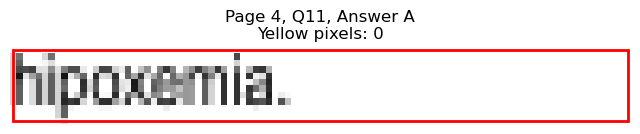

Page 4, Q11 - B: Detected box: x0=68.3, y0=709.6, x1=197.6, y1=720.7
Page 4, Q11, B: Yellow pixels: 0
Page 4, Q11, B: Total non-white pixels: 626
Page 4, Q11, B: Yellow percentage: 0.0%


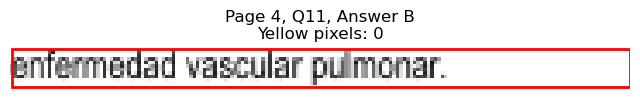

Page 4, Q11 - C: Detected box: x0=327.5, y0=697.0, x1=413.3, y1=708.1
Page 4, Q11, C: Yellow pixels: 1207
Page 4, Q11, C: Total non-white pixels: 1507
Page 4, Q11, C: Yellow percentage: 80.1%


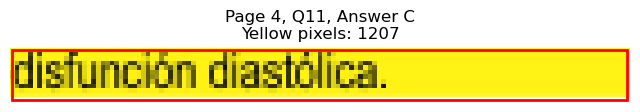

Page 4, Q11 - D: Detected box: x0=327.5, y0=709.6, x1=396.8, y1=720.7
Page 4, Q11, D: Yellow pixels: 0
Page 4, Q11, D: Total non-white pixels: 340
Page 4, Q11, D: Yellow percentage: 0.0%


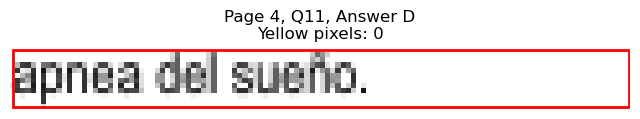


Page 4, Q11 - Selected Answer: C (based on yellow pixel count)





Page 5: Found 11 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=131.5, y1=114.8
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 329
Page 5, Q1, A: Yellow percentage: 0.0%


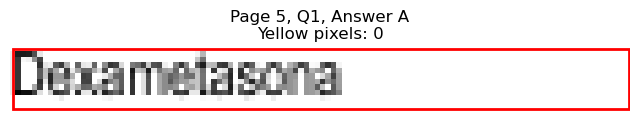

Page 5, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=109.9, y1=127.4
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 203
Page 5, Q1, B: Yellow percentage: 0.0%


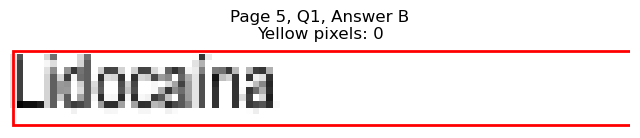

Page 5, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=367.1, y1=114.8
Page 5, Q1, C: Yellow pixels: 91
Page 5, Q1, C: Total non-white pixels: 290
Page 5, Q1, C: Yellow percentage: 31.4%


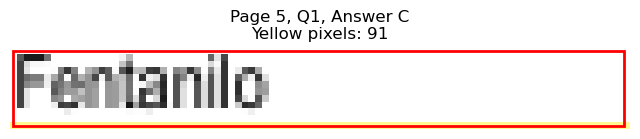

Page 5, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=402.8, y1=127.4
Page 5, Q1, D: Yellow pixels: 1090
Page 5, Q1, D: Total non-white pixels: 1512
Page 5, Q1, D: Yellow percentage: 72.1%


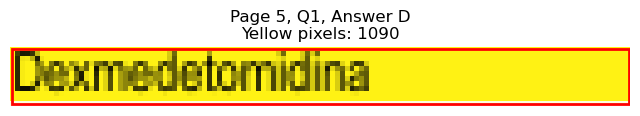


Page 5, Q1 - Selected Answer: D (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=154.3, x1=115.4, y1=165.3
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 247
Page 5, Q2, A: Yellow percentage: 0.0%


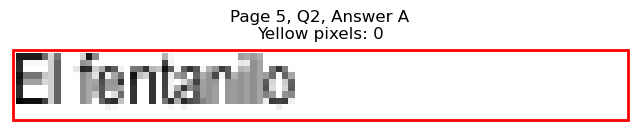

Page 5, Q2 - B: Detected box: x0=68.3, y0=166.9, x1=124.9, y1=177.9
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 270
Page 5, Q2, B: Yellow percentage: 0.0%


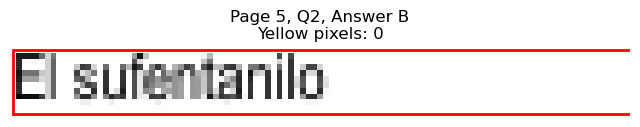

Page 5, Q2 - C: Detected box: x0=327.5, y0=154.3, x1=372.6, y1=165.3
Page 5, Q2, C: Yellow pixels: 896
Page 5, Q2, C: Total non-white pixels: 1152
Page 5, Q2, C: Yellow percentage: 77.8%


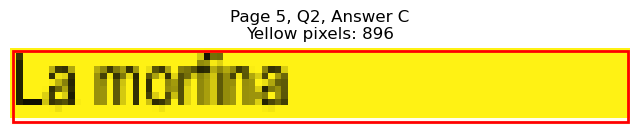

Page 5, Q2 - D: Detected box: x0=327.5, y0=166.9, x1=375.6, y1=177.9
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 228
Page 5, Q2, D: Yellow percentage: 0.0%


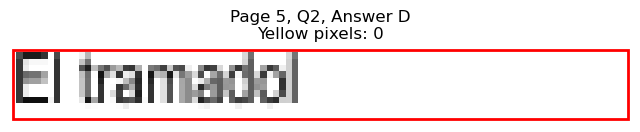


Page 5, Q2 - Selected Answer: C (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=217.4, x1=85.8, y1=228.4
Page 5, Q3, A: Yellow pixels: 68
Page 5, Q3, A: Total non-white pixels: 165
Page 5, Q3, A: Yellow percentage: 41.2%


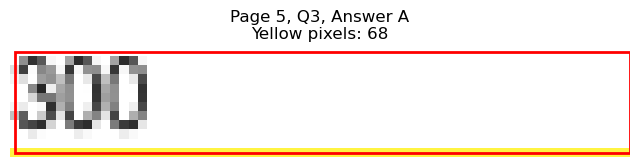

Page 5, Q3 - B: Detected box: x0=68.3, y0=230.0, x1=85.8, y1=241.0
Page 5, Q3, B: Yellow pixels: 754
Page 5, Q3, B: Total non-white pixels: 816
Page 5, Q3, B: Yellow percentage: 92.4%


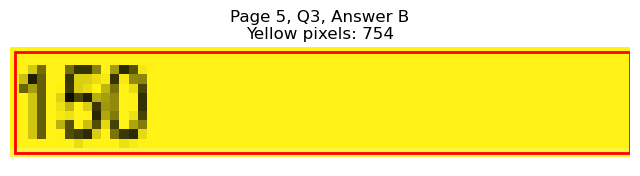

Page 5, Q3 - C: Detected box: x0=327.5, y0=217.4, x1=345.0, y1=228.4
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 75
Page 5, Q3, C: Yellow percentage: 0.0%


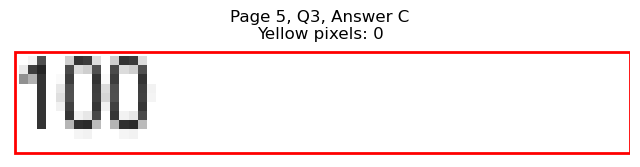

Page 5, Q3 - D: Detected box: x0=327.5, y0=230.0, x1=345.0, y1=241.0
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 88
Page 5, Q3, D: Yellow percentage: 0.0%


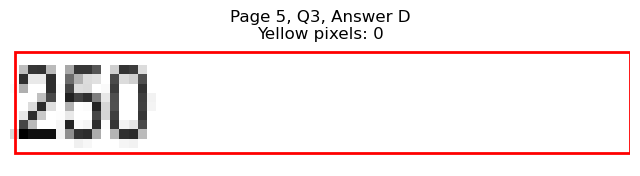


Page 5, Q3 - Selected Answer: B (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=280.5, x1=98.4, y1=291.6
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 103
Page 5, Q4, A: Yellow percentage: 0.0%


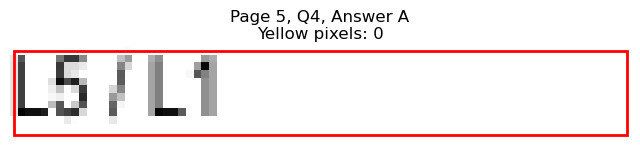

Page 5, Q4 - B: Detected box: x0=68.3, y0=293.1, x1=98.4, y1=304.2
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 110
Page 5, Q4, B: Yellow percentage: 0.0%


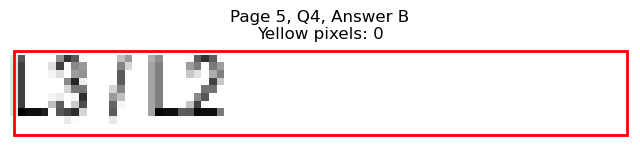

Page 5, Q4 - C: Detected box: x0=327.5, y0=280.5, x1=357.7, y1=291.6
Page 5, Q4, C: Yellow pixels: 81
Page 5, Q4, C: Total non-white pixels: 173
Page 5, Q4, C: Yellow percentage: 46.8%


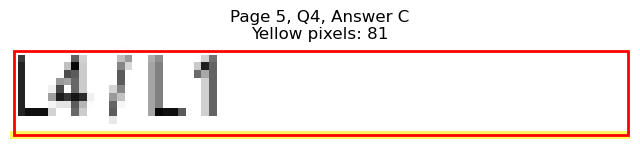

Page 5, Q4 - D: Detected box: x0=327.5, y0=293.1, x1=357.6, y1=304.2
Page 5, Q4, D: Yellow pixels: 813
Page 5, Q4, D: Total non-white pixels: 891
Page 5, Q4, D: Yellow percentage: 91.2%


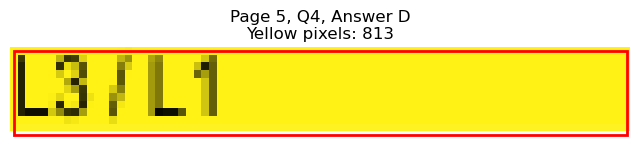


Page 5, Q4 - Selected Answer: D (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=343.6, x1=101.9, y1=354.7
Page 5, Q5, A: Yellow pixels: 900
Page 5, Q5, A: Total non-white pixels: 1008
Page 5, Q5, A: Yellow percentage: 89.3%


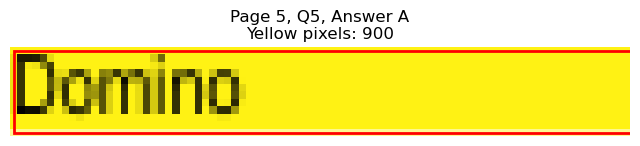

Page 5, Q5 - B: Detected box: x0=68.3, y0=356.2, x1=112.0, y1=367.3
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 228
Page 5, Q5, B: Yellow percentage: 0.0%


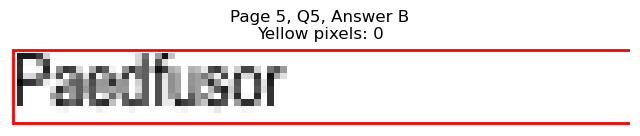

Page 5, Q5 - C: Detected box: x0=327.5, y0=343.6, x1=358.7, y1=354.7
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 167
Page 5, Q5, C: Yellow percentage: 0.0%


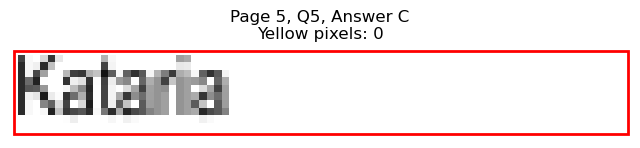

Page 5, Q5 - D: Detected box: x0=327.5, y0=356.2, x1=352.1, y1=367.3
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 130
Page 5, Q5, D: Yellow percentage: 0.0%


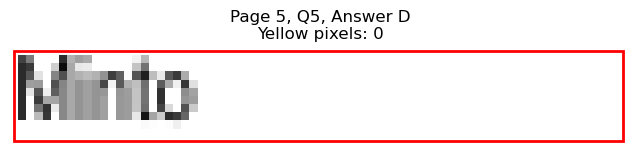


Page 5, Q5 - Selected Answer: A (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=394.0, x1=195.7, y1=405.1
Page 5, Q6, A: Yellow pixels: 1462
Page 5, Q6, A: Total non-white pixels: 1958
Page 5, Q6, A: Yellow percentage: 74.7%


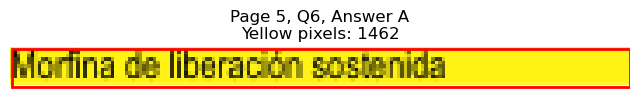

Page 5, Q6 - B: Detected box: x0=68.3, y0=406.6, x1=146.5, y1=417.7
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 400
Page 5, Q6, B: Yellow percentage: 0.0%


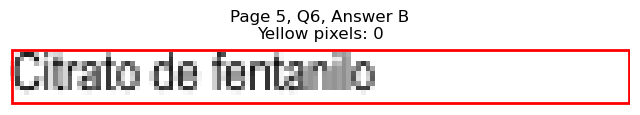

Page 5, Q6 - C: Detected box: x0=327.5, y0=394.0, x1=375.1, y1=405.1
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 252
Page 5, Q6, C: Yellow percentage: 0.0%


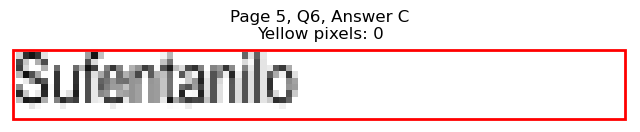

Page 5, Q6 - D: Detected box: x0=327.5, y0=406.6, x1=420.7, y1=417.7
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 499
Page 5, Q6, D: Yellow percentage: 0.0%


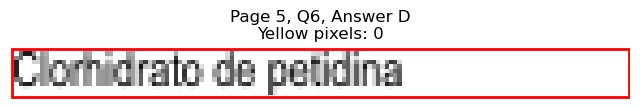


Page 5, Q6 - Selected Answer: A (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=444.6, x1=267.4, y1=455.6
Page 5, Q7, A: Yellow pixels: 32
Page 5, Q7, A: Total non-white pixels: 1071
Page 5, Q7, A: Yellow percentage: 3.0%


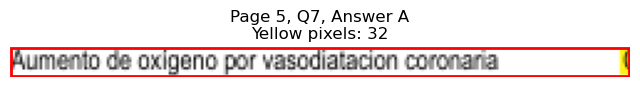

Page 5, Q7 - B: Detected box: x0=68.3, y0=457.2, x1=217.7, y1=468.2
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 800
Page 5, Q7, B: Yellow percentage: 0.0%


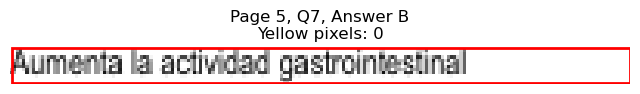

Page 5, Q7 - C: Detected box: x0=327.5, y0=444.6, x1=513.1, y1=455.6
Page 5, Q7, C: Yellow pixels: 1657
Page 5, Q7, C: Total non-white pixels: 2556
Page 5, Q7, C: Yellow percentage: 64.8%


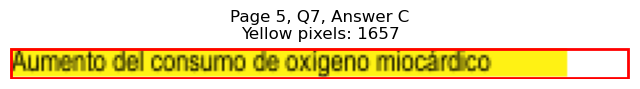

Page 5, Q7 - D: Detected box: x0=327.5, y0=457.2, x1=505.6, y1=468.2
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 925
Page 5, Q7, D: Yellow percentage: 0.0%


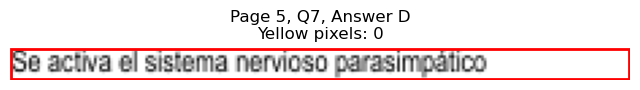


Page 5, Q7 - Selected Answer: C (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=495.1, x1=286.0, y1=506.1
Page 5, Q8, A: Yellow pixels: 268
Page 5, Q8, A: Total non-white pixels: 1607
Page 5, Q8, A: Yellow percentage: 16.7%


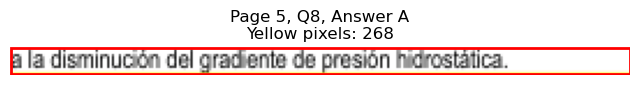

Page 5, Q8 - B: Detected box: x0=68.3, y0=507.7, x1=324.0, y1=518.7
Page 5, Q8, B: Yellow pixels: 2754
Page 5, Q8, B: Total non-white pixels: 3672
Page 5, Q8, B: Yellow percentage: 75.0%


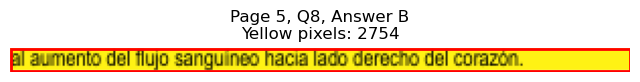

Page 5, Q8 - C: Detected box: x0=68.8, y0=520.3, x1=298.0, y1=531.3
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 1151
Page 5, Q8, C: Yellow percentage: 0.0%


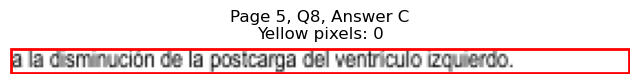

Page 5, Q8 - D: Detected box: x0=68.8, y0=532.9, x1=225.2, y1=543.9
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 745
Page 5, Q8, D: Yellow percentage: 0.0%


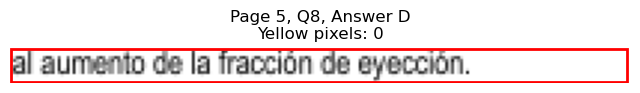


Page 5, Q8 - Selected Answer: B (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=583.4, x1=164.6, y1=594.4
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 484
Page 5, Q9, A: Yellow percentage: 0.0%


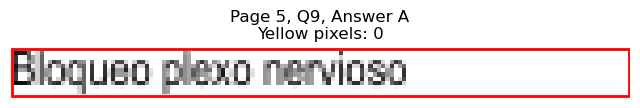

Page 5, Q9 - B: Detected box: x0=68.3, y0=596.0, x1=145.1, y1=607.0
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 395
Page 5, Q9, B: Yellow percentage: 0.0%


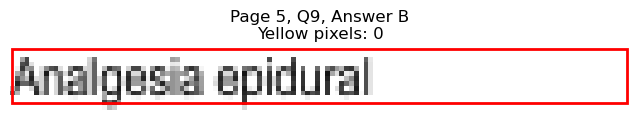

Page 5, Q9 - C: Detected box: x0=327.5, y0=583.4, x1=407.3, y1=594.4
Page 5, Q9, C: Yellow pixels: 131
Page 5, Q9, C: Total non-white pixels: 535
Page 5, Q9, C: Yellow percentage: 24.5%


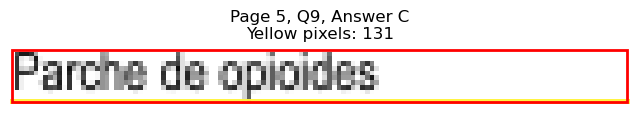

Page 5, Q9 - D: Detected box: x0=327.5, y0=596.0, x1=415.8, y1=607.0
Page 5, Q9, D: Yellow pixels: 1318
Page 5, Q9, D: Total non-white pixels: 1671
Page 5, Q9, D: Yellow percentage: 78.9%


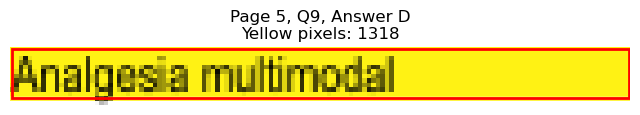


Page 5, Q9 - Selected Answer: D (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=68.3, y0=659.1, x1=113.4, y1=670.2
Page 5, Q10, A: Yellow pixels: 0
Page 5, Q10, A: Total non-white pixels: 241
Page 5, Q10, A: Yellow percentage: 0.0%


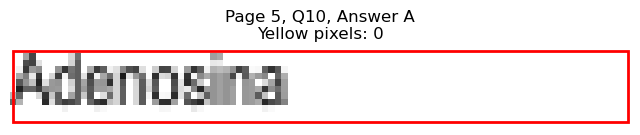

Page 5, Q10 - B: Detected box: x0=68.3, y0=671.7, x1=119.4, y1=682.8
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 269
Page 5, Q10, B: Yellow percentage: 0.0%


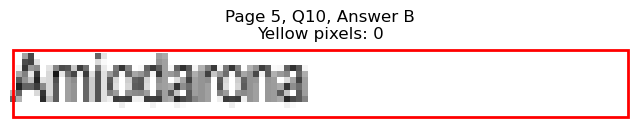

Page 5, Q10 - C: Detected box: x0=327.5, y0=659.1, x1=428.8, y1=670.2
Page 5, Q10, C: Yellow pixels: 152
Page 5, Q10, C: Total non-white pixels: 832
Page 5, Q10, C: Yellow percentage: 18.3%


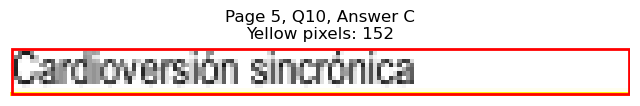

Page 5, Q10 - D: Detected box: x0=327.5, y0=671.7, x1=373.2, y1=682.8
Page 5, Q10, D: Yellow pixels: 1008
Page 5, Q10, D: Total non-white pixels: 1164
Page 5, Q10, D: Yellow percentage: 86.6%


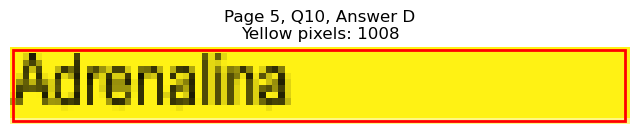


Page 5, Q10 - Selected Answer: D (based on yellow pixel count)




Page 5, Q11 - A: Detected box: x0=68.3, y0=734.8, x1=109.0, y1=745.9
Page 5, Q11, A: Yellow pixels: 952
Page 5, Q11, A: Total non-white pixels: 1092
Page 5, Q11, A: Yellow percentage: 87.2%


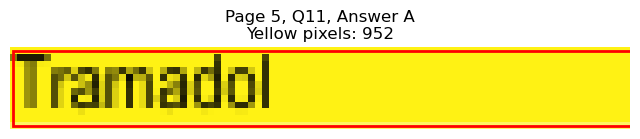

Page 5, Q11 - B: Detected box: x0=68.3, y0=747.4, x1=107.9, y1=758.5
Page 5, Q11, B: Yellow pixels: 0
Page 5, Q11, B: Total non-white pixels: 179
Page 5, Q11, B: Yellow percentage: 0.0%


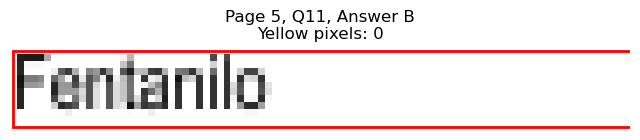

Page 5, Q11 - C: Detected box: x0=327.5, y0=734.8, x1=370.1, y1=745.9
Page 5, Q11, C: Yellow pixels: 0
Page 5, Q11, C: Total non-white pixels: 226
Page 5, Q11, C: Yellow percentage: 0.0%


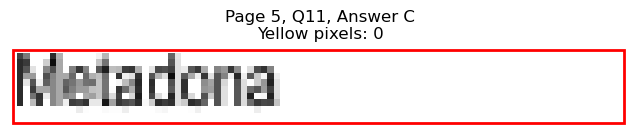

Page 5, Q11 - D: Detected box: x0=327.5, y0=747.4, x1=370.7, y1=758.5
Page 5, Q11, D: Yellow pixels: 0
Page 5, Q11, D: Total non-white pixels: 231
Page 5, Q11, D: Yellow percentage: 0.0%


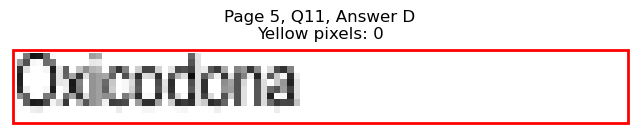


Page 5, Q11 - Selected Answer: A (based on yellow pixel count)





Page 6: Found 10 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=406.6, x1=106.9, y1=417.7
Page 6, Q1, A: Yellow pixels: 938
Page 6, Q1, A: Total non-white pixels: 1068
Page 6, Q1, A: Yellow percentage: 87.8%


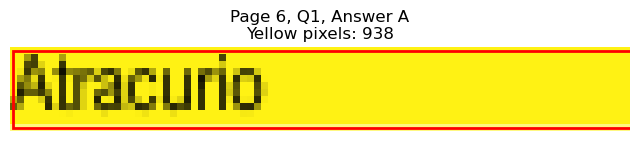

Page 6, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=110.0, y1=114.8
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 178
Page 6, Q1, B: Yellow percentage: 0.0%


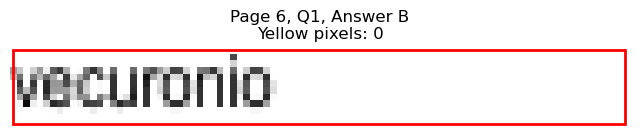

Page 6, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=383.2, y1=102.2
Page 6, Q1, C: Yellow pixels: 954
Page 6, Q1, C: Total non-white pixels: 1177
Page 6, Q1, C: Yellow percentage: 81.1%


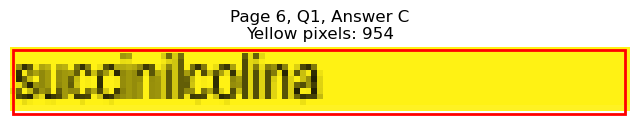

Page 6, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=376.7, y1=114.8
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 239
Page 6, Q1, D: Yellow percentage: 0.0%


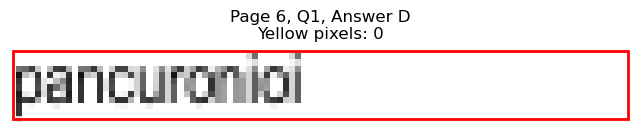


Page 6, Q1 - Selected Answer: C (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=166.9, x1=80.9, y1=177.9
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 130
Page 6, Q2, A: Yellow percentage: 0.0%


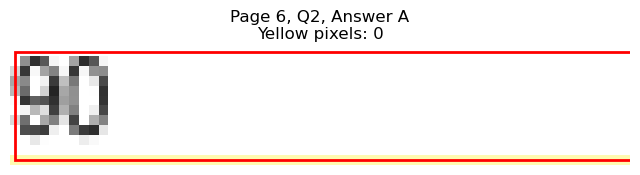

Page 6, Q2 - B: Detected box: x0=68.3, y0=179.5, x1=85.8, y1=190.5
Page 6, Q2, B: Yellow pixels: 677
Page 6, Q2, B: Total non-white pixels: 816
Page 6, Q2, B: Yellow percentage: 83.0%


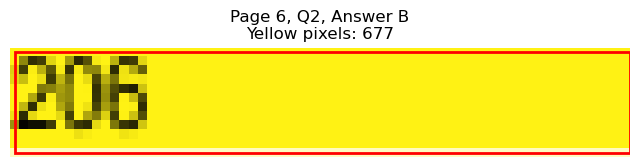

Page 6, Q2 - C: Detected box: x0=327.5, y0=166.9, x1=345.0, y1=177.9
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 83
Page 6, Q2, C: Yellow percentage: 0.0%


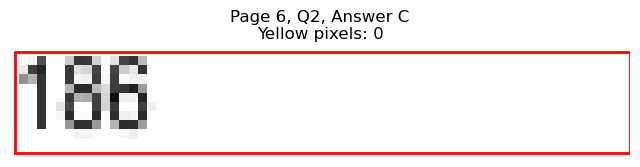

Page 6, Q2 - D: Detected box: x0=327.5, y0=179.5, x1=340.1, y1=190.5
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 65
Page 6, Q2, D: Yellow percentage: 0.0%


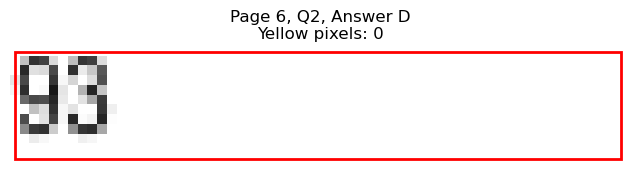


Page 6, Q2 - Selected Answer: B (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=230.0, x1=126.5, y1=241.0
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 307
Page 6, Q3, A: Yellow percentage: 0.0%


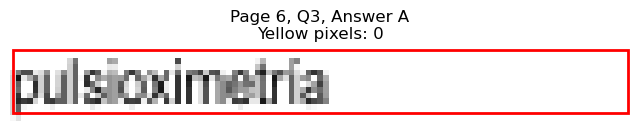

Page 6, Q3 - B: Detected box: x0=68.3, y0=242.6, x1=127.4, y1=253.6
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 342
Page 6, Q3, B: Yellow percentage: 0.0%


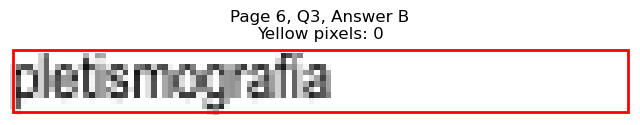

Page 6, Q3 - C: Detected box: x0=327.5, y0=230.0, x1=377.6, y1=241.0
Page 6, Q3, C: Yellow pixels: 994
Page 6, Q3, C: Total non-white pixels: 1217
Page 6, Q3, C: Yellow percentage: 81.7%


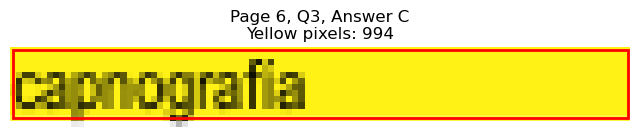

Page 6, Q3 - D: Detected box: x0=327.5, y0=242.6, x1=400.7, y1=253.6
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 353
Page 6, Q3, D: Yellow percentage: 0.0%


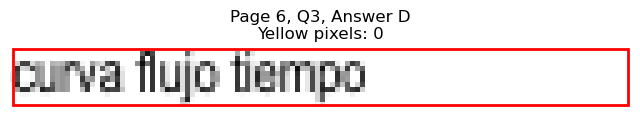


Page 6, Q3 - Selected Answer: C (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=56.6, y0=293.1, x1=65.2, y1=304.2
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 77
Page 6, Q4, A: Yellow percentage: 0.0%


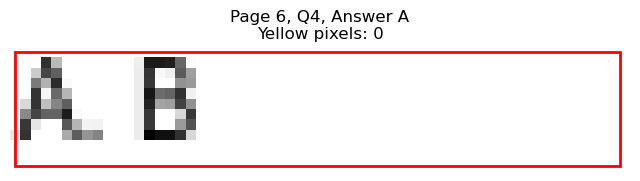

Page 6, Q4 - B: Detected box: x0=68.3, y0=305.7, x1=77.3, y1=316.8
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 34
Page 6, Q4, B: Yellow percentage: 0.0%


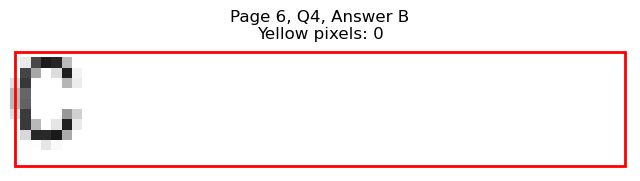

Page 6, Q4 - C: Detected box: x0=327.5, y0=293.1, x1=336.5, y1=304.2
Page 6, Q4, C: Yellow pixels: 60
Page 6, Q4, C: Total non-white pixels: 157
Page 6, Q4, C: Yellow percentage: 38.2%


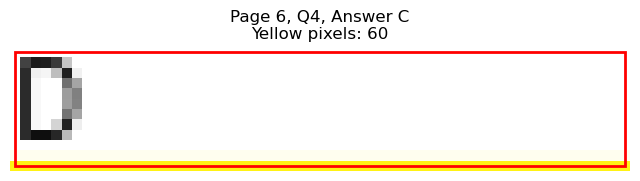

Page 6, Q4 - D: Detected box: x0=315.4, y0=305.7, x1=324.4, y1=316.8
Page 6, Q4, D: Yellow pixels: 669
Page 6, Q4, D: Total non-white pixels: 720
Page 6, Q4, D: Yellow percentage: 92.9%


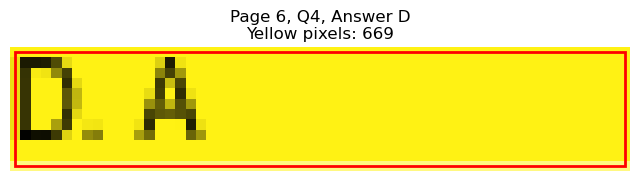


Page 6, Q4 - Selected Answer: D (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=56.6, y0=356.2, x1=65.2, y1=367.3
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 64
Page 6, Q5, A: Yellow percentage: 0.0%


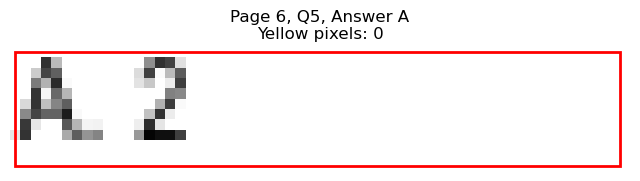

Page 6, Q5 - B: Detected box: x0=56.6, y0=368.8, x1=65.2, y1=379.9
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 73
Page 6, Q5, B: Yellow percentage: 0.0%


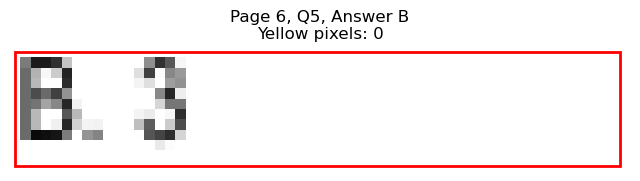

Page 6, Q5 - C: Detected box: x0=315.4, y0=356.2, x1=324.4, y1=367.3
Page 6, Q5, C: Yellow pixels: 60
Page 6, Q5, C: Total non-white pixels: 130
Page 6, Q5, C: Yellow percentage: 46.2%


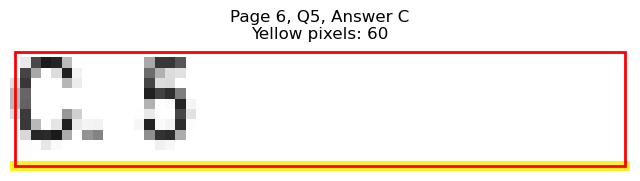

Page 6, Q5 - D: Detected box: x0=315.4, y0=368.8, x1=324.4, y1=379.9
Page 6, Q5, D: Yellow pixels: 670
Page 6, Q5, D: Total non-white pixels: 720
Page 6, Q5, D: Yellow percentage: 93.1%


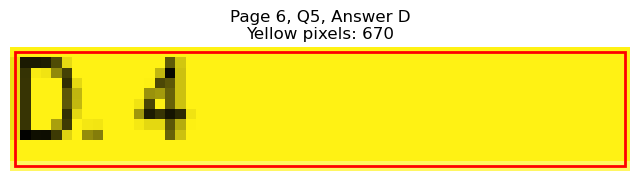


Page 6, Q5 - Selected Answer: D (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=406.6, x1=106.9, y1=417.7
Page 6, Q6, A: Yellow pixels: 938
Page 6, Q6, A: Total non-white pixels: 1068
Page 6, Q6, A: Yellow percentage: 87.8%


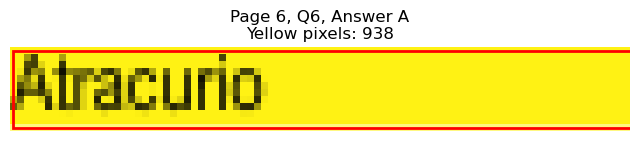

Page 6, Q6 - B: Detected box: x0=68.3, y0=419.4, x1=125.4, y1=430.4
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 286
Page 6, Q6, B: Yellow percentage: 0.0%


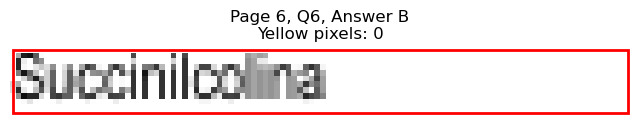

Page 6, Q6 - C: Detected box: x0=327.5, y0=406.6, x1=370.6, y1=417.7
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 218
Page 6, Q6, C: Yellow percentage: 0.0%


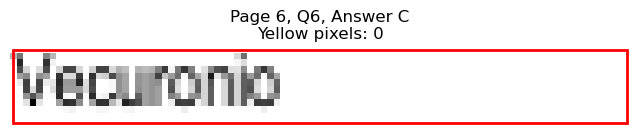

Page 6, Q6 - D: Detected box: x0=327.5, y0=419.4, x1=371.2, y1=430.4
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 207
Page 6, Q6, D: Yellow percentage: 0.0%


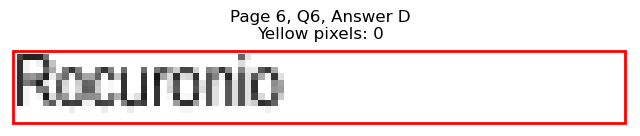


Page 6, Q6 - Selected Answer: A (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=469.8, x1=260.9, y1=480.8
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 924
Page 6, Q7, A: Yellow percentage: 0.0%


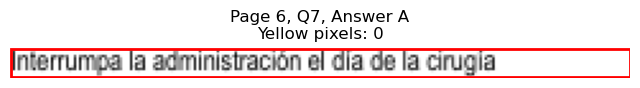

Page 6, Q7 - B: Detected box: x0=68.3, y0=482.5, x1=270.5, y1=493.5
Page 6, Q7, B: Yellow pixels: 253
Page 6, Q7, B: Total non-white pixels: 1236
Page 6, Q7, B: Yellow percentage: 20.5%


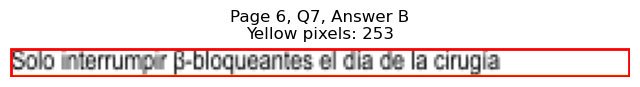

Page 6, Q7 - C: Detected box: x0=68.8, y0=495.1, x1=273.4, y1=506.1
Page 6, Q7, C: Yellow pixels: 2049
Page 6, Q7, C: Total non-white pixels: 2819
Page 6, Q7, C: Yellow percentage: 72.7%


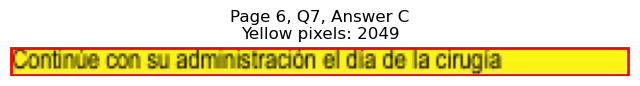

Page 6, Q7 - D: Detected box: x0=68.8, y0=507.7, x1=292.0, y1=518.7
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 1111
Page 6, Q7, D: Yellow percentage: 0.0%


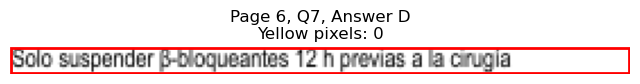


Page 6, Q7 - Selected Answer: C (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=558.2, x1=109.0, y1=569.2
Page 6, Q8, A: Yellow pixels: 852
Page 6, Q8, A: Total non-white pixels: 1001
Page 6, Q8, A: Yellow percentage: 85.1%


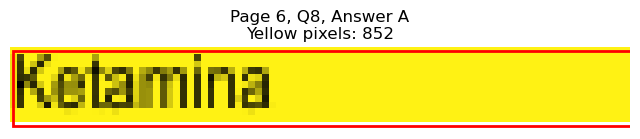

Page 6, Q8 - B: Detected box: x0=68.3, y0=570.8, x1=104.5, y1=581.8
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 190
Page 6, Q8, B: Yellow percentage: 0.0%


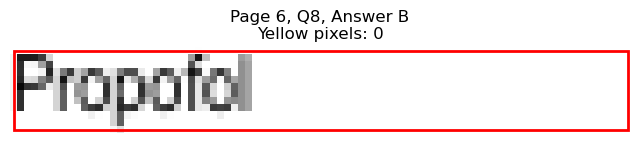

Page 6, Q8 - C: Detected box: x0=327.5, y0=558.2, x1=370.6, y1=569.2
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 222
Page 6, Q8, C: Yellow percentage: 0.0%


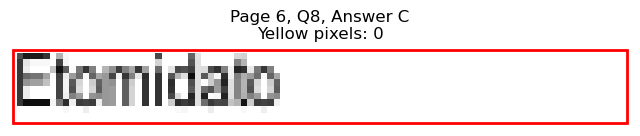

Page 6, Q8 - D: Detected box: x0=327.5, y0=570.8, x1=402.8, y1=581.8
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 394
Page 6, Q8, D: Yellow percentage: 0.0%


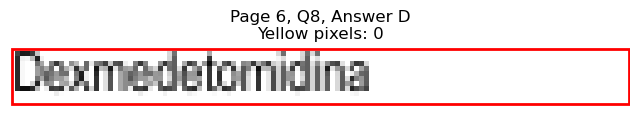


Page 6, Q8 - Selected Answer: A (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=621.3, x1=164.0, y1=632.4
Page 6, Q9, A: Yellow pixels: 147
Page 6, Q9, A: Total non-white pixels: 656
Page 6, Q9, A: Yellow percentage: 22.4%


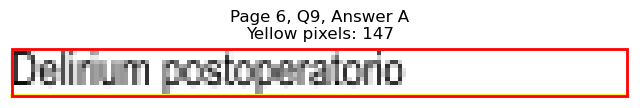

Page 6, Q9 - B: Detected box: x0=68.3, y0=633.9, x1=158.0, y1=645.0
Page 6, Q9, B: Yellow pixels: 1325
Page 6, Q9, B: Total non-white pixels: 1692
Page 6, Q9, B: Yellow percentage: 78.3%


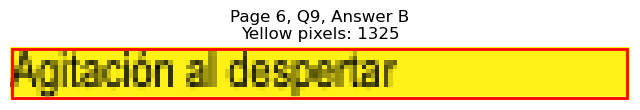

Page 6, Q9 - C: Detected box: x0=327.5, y0=621.3, x1=511.1, y1=632.4
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 939
Page 6, Q9, C: Yellow percentage: 0.0%


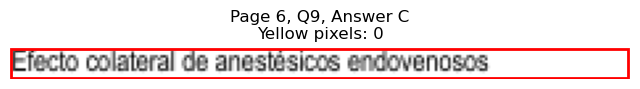

Page 6, Q9 - D: Detected box: x0=327.5, y0=633.9, x1=390.2, y1=645.0
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 347
Page 6, Q9, D: Yellow percentage: 0.0%


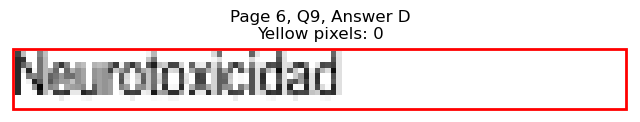


Page 6, Q9 - Selected Answer: B (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=68.3, y0=684.3, x1=100.9, y1=695.4
Page 6, Q10, A: Yellow pixels: 0
Page 6, Q10, A: Total non-white pixels: 178
Page 6, Q10, A: Yellow percentage: 0.0%


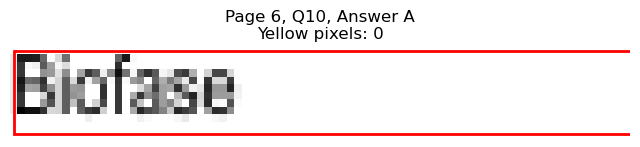

Page 6, Q10 - B: Detected box: x0=68.3, y0=697.0, x1=159.7, y1=708.1
Page 6, Q10, B: Yellow pixels: 0
Page 6, Q10, B: Total non-white pixels: 447
Page 6, Q10, B: Yellow percentage: 0.0%


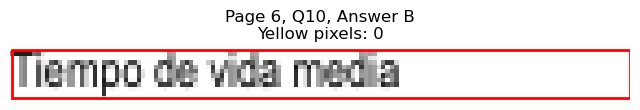

Page 6, Q10 - C: Detected box: x0=327.5, y0=684.3, x1=369.6, y1=695.4
Page 6, Q10, C: Yellow pixels: 842
Page 6, Q10, C: Total non-white pixels: 1116
Page 6, Q10, C: Yellow percentage: 75.4%


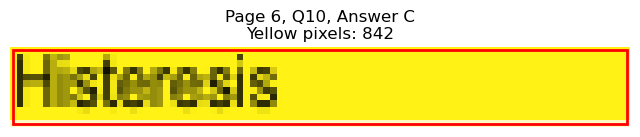

Page 6, Q10 - D: Detected box: x0=327.5, y0=697.0, x1=374.6, y1=708.1
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 246
Page 6, Q10, D: Yellow percentage: 0.0%


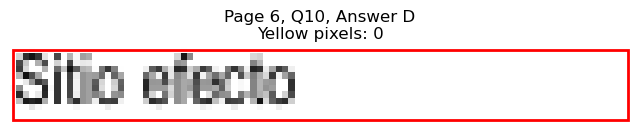


Page 6, Q10 - Selected Answer: C (based on yellow pixel count)





Page 7: Found 10 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=264.8, y1=114.8
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 970
Page 7, Q1, A: Yellow percentage: 0.0%


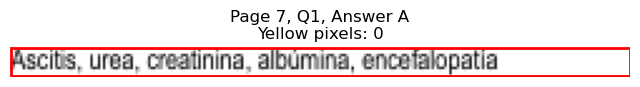

Page 7, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=298.6, y1=127.4
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 1221
Page 7, Q1, B: Yellow percentage: 0.0%


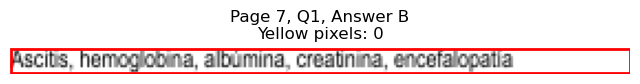

Page 7, Q1 - C: Detected box: x0=68.8, y0=129.0, x1=335.2, y1=140.0
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 1574
Page 7, Q1, C: Yellow percentage: 0.0%


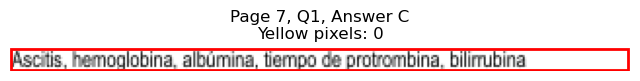

Page 7, Q1 - D: Detected box: x0=68.8, y0=141.7, x1=337.6, y1=152.7
Page 7, Q1, D: Yellow pixels: 2688
Page 7, Q1, D: Total non-white pixels: 3840
Page 7, Q1, D: Yellow percentage: 70.0%


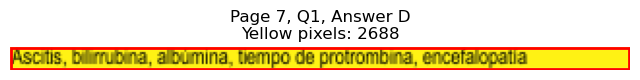


Page 7, Q1 - Selected Answer: D (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=192.1, x1=162.6, y1=203.1
Page 7, Q2, A: Yellow pixels: 1201
Page 7, Q2, A: Total non-white pixels: 1598
Page 7, Q2, A: Yellow percentage: 75.2%


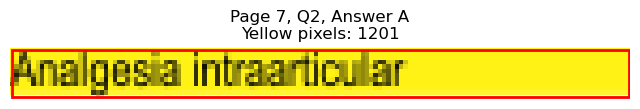

Page 7, Q2 - B: Detected box: x0=68.3, y0=204.7, x1=133.4, y1=215.7
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 328
Page 7, Q2, B: Yellow percentage: 0.0%


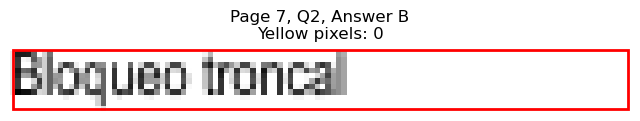

Page 7, Q2 - C: Detected box: x0=327.5, y0=192.1, x1=417.7, y1=203.1
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 462
Page 7, Q2, C: Yellow percentage: 0.0%


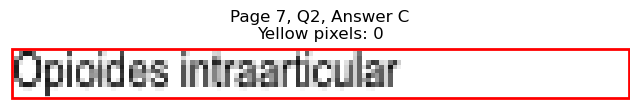

Page 7, Q2 - D: Detected box: x0=327.5, y0=204.7, x1=394.2, y1=215.7
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 321
Page 7, Q2, D: Yellow percentage: 0.0%


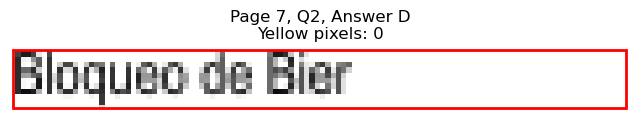


Page 7, Q2 - Selected Answer: A (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=255.2, x1=287.9, y1=266.2
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 1107
Page 7, Q3, A: Yellow percentage: 0.0%


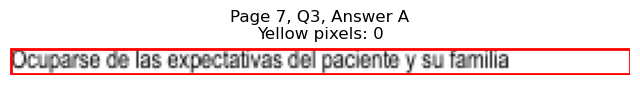

Page 7, Q3 - B: Detected box: x0=68.3, y0=267.8, x1=296.0, y1=278.8
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 1431
Page 7, Q3, B: Yellow percentage: 0.0%


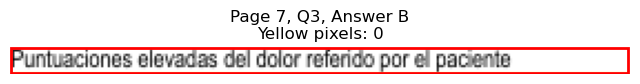

Page 7, Q3 - C: Detected box: x0=68.8, y0=280.5, x1=247.3, y1=291.6
Page 7, Q3, C: Yellow pixels: 1833
Page 7, Q3, C: Total non-white pixels: 2760
Page 7, Q3, C: Yellow percentage: 66.4%


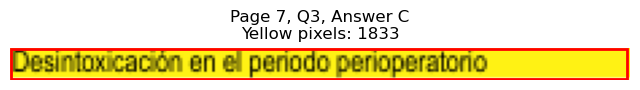

Page 7, Q3 - D: Detected box: x0=68.8, y0=293.1, x1=268.9, y1=304.2
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 1048
Page 7, Q3, D: Yellow percentage: 0.0%


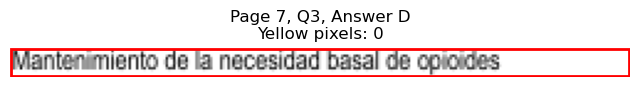


Page 7, Q3 - Selected Answer: C (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=343.6, x1=115.9, y1=354.7
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 260
Page 7, Q4, A: Yellow percentage: 0.0%


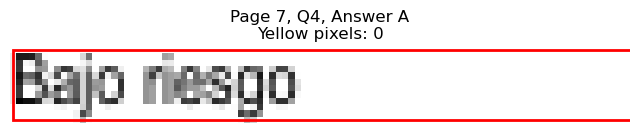

Page 7, Q4 - B: Detected box: x0=68.3, y0=356.2, x1=143.5, y1=367.3
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 405
Page 7, Q4, B: Yellow percentage: 0.0%


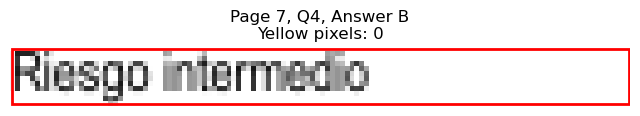

Page 7, Q4 - C: Detected box: x0=327.5, y0=343.6, x1=372.6, y1=354.7
Page 7, Q4, C: Yellow pixels: 982
Page 7, Q4, C: Total non-white pixels: 1152
Page 7, Q4, C: Yellow percentage: 85.2%


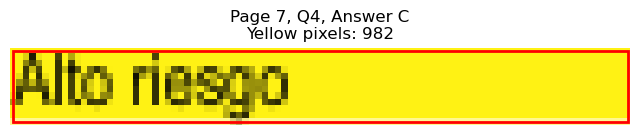

Page 7, Q4 - D: Detected box: x0=327.5, y0=356.2, x1=390.7, y1=367.3
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 323
Page 7, Q4, D: Yellow percentage: 0.0%


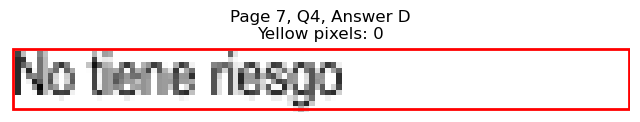


Page 7, Q4 - Selected Answer: C (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=406.6, x1=114.5, y1=417.7
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 250
Page 7, Q5, A: Yellow percentage: 0.0%


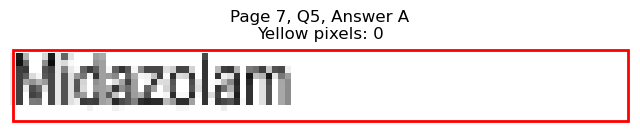

Page 7, Q5 - B: Detected box: x0=68.3, y0=419.4, x1=143.5, y1=430.4
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 415
Page 7, Q5, B: Yellow percentage: 0.0%


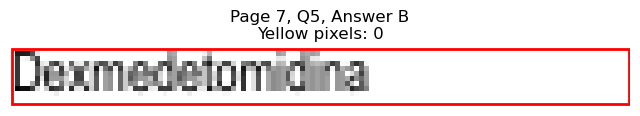

Page 7, Q5 - C: Detected box: x0=327.5, y0=406.6, x1=378.7, y1=417.7
Page 7, Q5, C: Yellow pixels: 1021
Page 7, Q5, C: Total non-white pixels: 1224
Page 7, Q5, C: Yellow percentage: 83.4%


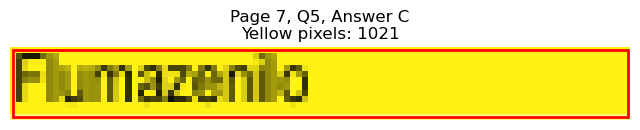

Page 7, Q5 - D: Detected box: x0=327.5, y0=419.4, x1=370.1, y1=430.4
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 226
Page 7, Q5, D: Yellow percentage: 0.0%


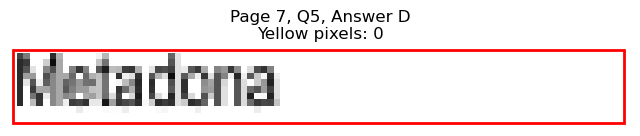


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=457.2, x1=226.8, y1=468.2
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 754
Page 7, Q6, A: Yellow percentage: 0.0%


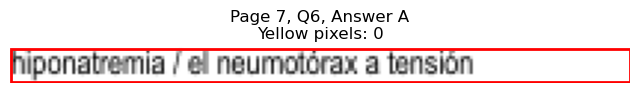

Page 7, Q6 - B: Detected box: x0=68.3, y0=469.8, x1=222.2, y1=480.8
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 768
Page 7, Q6, B: Yellow percentage: 0.0%


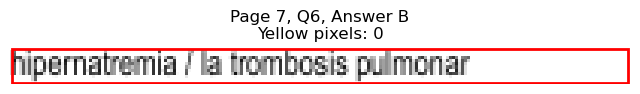

Page 7, Q6 - C: Detected box: x0=327.5, y0=457.2, x1=480.5, y1=468.2
Page 7, Q6, C: Yellow pixels: 1673
Page 7, Q6, C: Total non-white pixels: 2247
Page 7, Q6, C: Yellow percentage: 74.5%


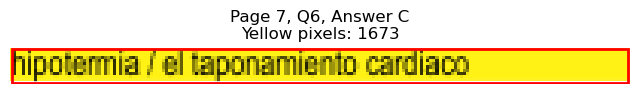

Page 7, Q6 - D: Detected box: x0=327.5, y0=469.8, x1=478.4, y1=480.8
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 754
Page 7, Q6, D: Yellow percentage: 0.0%


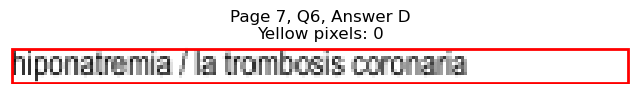


Page 7, Q6 - Selected Answer: C (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=56.6, y0=532.9, x1=65.2, y1=543.9
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 44
Page 7, Q7, A: Yellow percentage: 0.0%


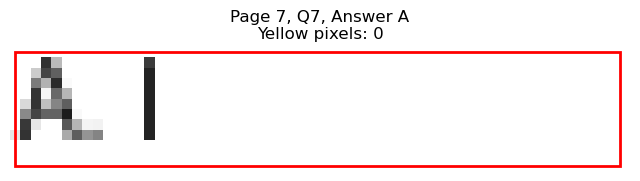

Page 7, Q7 - B: Detected box: x0=68.3, y0=545.5, x1=78.4, y1=556.5
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 32
Page 7, Q7, B: Yellow percentage: 0.0%


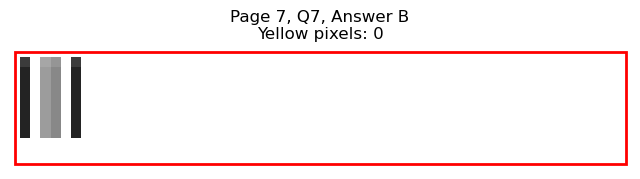

Page 7, Q7 - C: Detected box: x0=315.4, y0=532.9, x1=324.4, y1=543.9
Page 7, Q7, C: Yellow pixels: 671
Page 7, Q7, C: Total non-white pixels: 720
Page 7, Q7, C: Yellow percentage: 93.2%


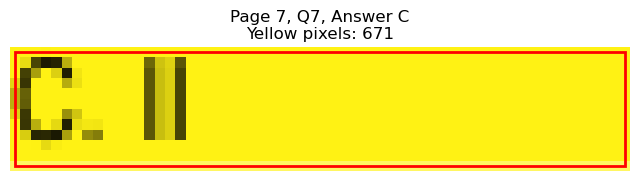

Page 7, Q7 - D: Detected box: x0=327.5, y0=545.5, x1=338.5, y1=556.5
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 43
Page 7, Q7, D: Yellow percentage: 0.0%


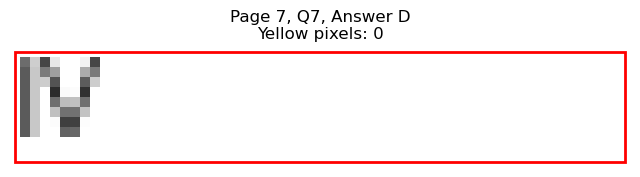


Page 7, Q7 - Selected Answer: C (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=596.0, x1=156.0, y1=607.0
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 438
Page 7, Q8, A: Yellow percentage: 0.0%


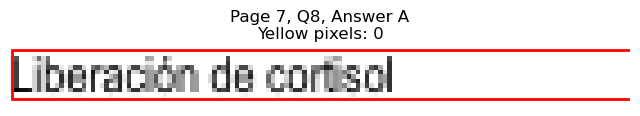

Page 7, Q8 - B: Detected box: x0=68.3, y0=608.6, x1=165.6, y1=619.6
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 503
Page 7, Q8, B: Yellow percentage: 0.0%


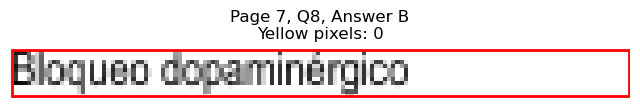

Page 7, Q8 - C: Detected box: x0=327.5, y0=596.0, x1=476.0, y1=607.0
Page 7, Q8, C: Yellow pixels: 1823
Page 7, Q8, C: Total non-white pixels: 2403
Page 7, Q8, C: Yellow percentage: 75.9%


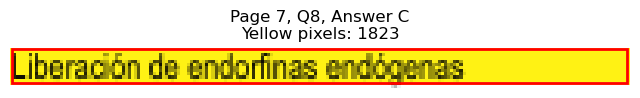

Page 7, Q8 - D: Detected box: x0=327.5, y0=608.6, x1=490.9, y1=619.6
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 845
Page 7, Q8, D: Yellow percentage: 0.0%


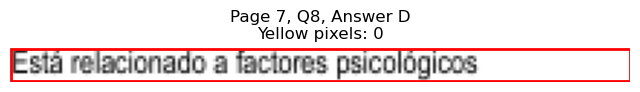


Page 7, Q8 - Selected Answer: C (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=646.5, x1=104.4, y1=657.6
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 188
Page 7, Q9, A: Yellow percentage: 0.0%


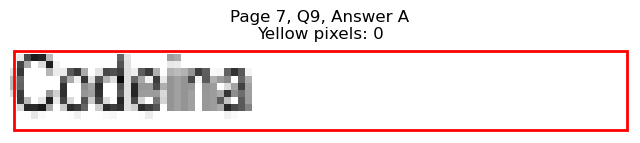

Page 7, Q9 - B: Detected box: x0=68.3, y0=659.1, x1=122.4, y1=670.2
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 283
Page 7, Q9, B: Yellow percentage: 0.0%


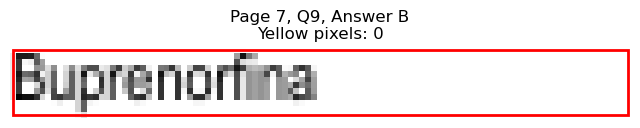

Page 7, Q9 - C: Detected box: x0=327.5, y0=646.5, x1=368.2, y1=657.6
Page 7, Q9, C: Yellow pixels: 868
Page 7, Q9, C: Total non-white pixels: 1104
Page 7, Q9, C: Yellow percentage: 78.6%


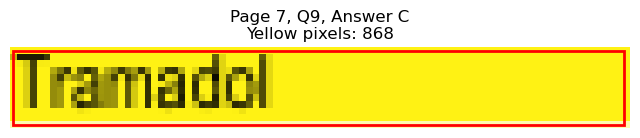

Page 7, Q9 - D: Detected box: x0=327.5, y0=659.1, x1=368.2, y1=670.2
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 215
Page 7, Q9, D: Yellow percentage: 0.0%


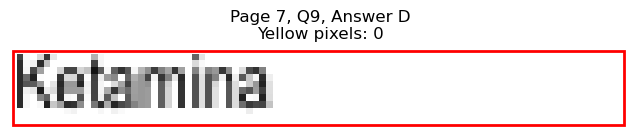


Page 7, Q9 - Selected Answer: C (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=68.3, y0=709.6, x1=111.4, y1=720.7
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 247
Page 7, Q10, A: Yellow percentage: 0.0%


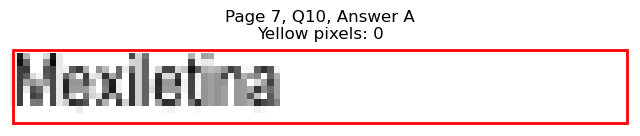

Page 7, Q10 - B: Detected box: x0=68.3, y0=722.2, x1=122.5, y1=733.3
Page 7, Q10, B: Yellow pixels: 0
Page 7, Q10, B: Total non-white pixels: 279
Page 7, Q10, B: Yellow percentage: 0.0%


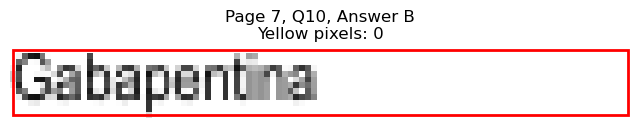

Page 7, Q10 - C: Detected box: x0=327.5, y0=709.6, x1=378.1, y1=720.7
Page 7, Q10, C: Yellow pixels: 102
Page 7, Q10, C: Total non-white pixels: 366
Page 7, Q10, C: Yellow percentage: 27.9%


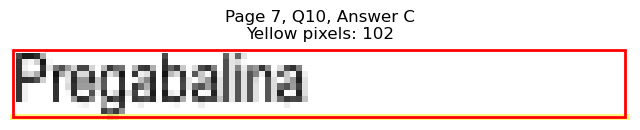

Page 7, Q10 - D: Detected box: x0=327.5, y0=722.2, x1=391.3, y1=733.3
Page 7, Q10, D: Yellow pixels: 1004
Page 7, Q10, D: Total non-white pixels: 1380
Page 7, Q10, D: Yellow percentage: 72.8%


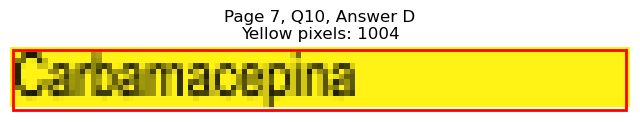


Page 7, Q10 - Selected Answer: D (based on yellow pixel count)





Page 8: Found 10 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=233.9, y1=127.4
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 842
Page 8, Q1, A: Yellow percentage: 0.0%


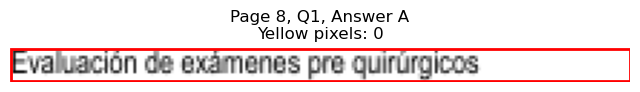

Page 8, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=167.6, y1=140.0
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 641
Page 8, Q1, B: Yellow percentage: 0.0%


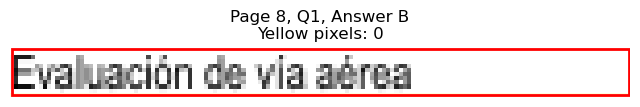

Page 8, Q1 - C: Detected box: x0=68.8, y0=141.7, x1=322.0, y1=152.7
Page 8, Q1, C: Yellow pixels: 2661
Page 8, Q1, C: Total non-white pixels: 3648
Page 8, Q1, C: Yellow percentage: 72.9%


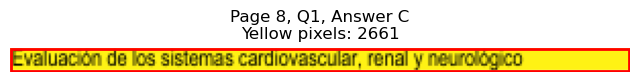

Page 8, Q1 - D: Detected box: x0=68.8, y0=154.3, x1=226.2, y1=165.3
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 811
Page 8, Q1, D: Yellow percentage: 0.0%


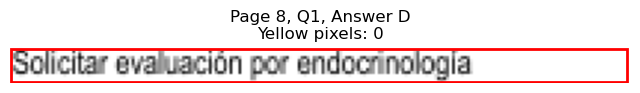


Page 8, Q1 - Selected Answer: C (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=204.7, x1=117.5, y1=215.7
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 266
Page 8, Q2, A: Yellow percentage: 0.0%


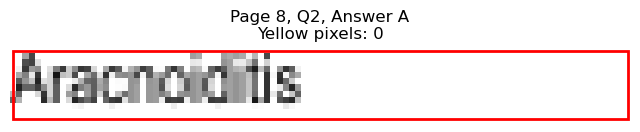

Page 8, Q2 - B: Detected box: x0=68.3, y0=217.4, x1=134.0, y1=228.4
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 313
Page 8, Q2, B: Yellow percentage: 0.0%


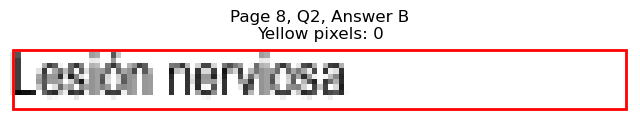

Page 8, Q2 - C: Detected box: x0=327.5, y0=204.7, x1=432.4, y1=215.7
Page 8, Q2, C: Yellow pixels: 1484
Page 8, Q2, C: Total non-white pixels: 1872
Page 8, Q2, C: Yellow percentage: 79.3%


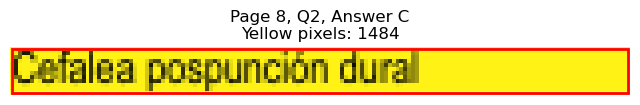

Page 8, Q2 - D: Detected box: x0=327.5, y0=217.4, x1=454.0, y1=228.4
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 615
Page 8, Q2, D: Yellow percentage: 0.0%


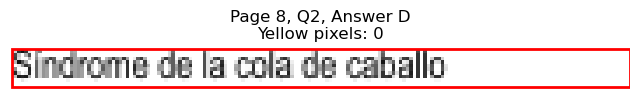


Page 8, Q2 - Selected Answer: C (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=255.2, x1=106.9, y1=266.2
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 184
Page 8, Q3, A: Yellow percentage: 0.0%


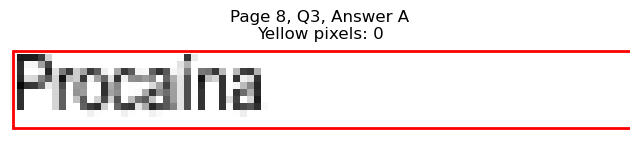

Page 8, Q3 - B: Detected box: x0=68.3, y0=267.8, x1=120.6, y1=278.8
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 283
Page 8, Q3, B: Yellow percentage: 0.0%


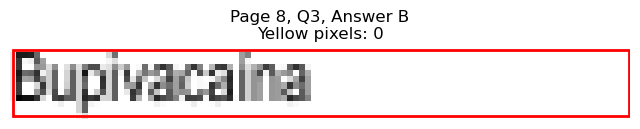

Page 8, Q3 - C: Detected box: x0=327.5, y0=255.2, x1=369.1, y1=266.2
Page 8, Q3, C: Yellow pixels: 888
Page 8, Q3, C: Total non-white pixels: 1023
Page 8, Q3, C: Yellow percentage: 86.8%


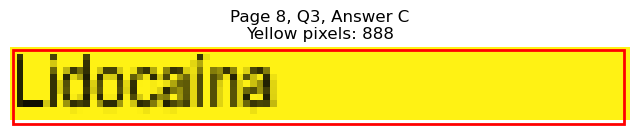

Page 8, Q3 - D: Detected box: x0=327.5, y0=267.8, x1=373.1, y1=278.8
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 221
Page 8, Q3, D: Yellow percentage: 0.0%


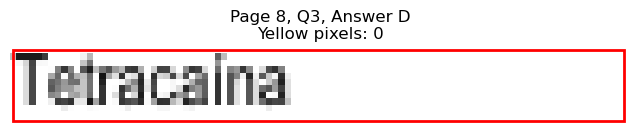


Page 8, Q3 - Selected Answer: C (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=318.3, x1=79.3, y1=329.4
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 36
Page 8, Q4, A: Yellow percentage: 0.0%


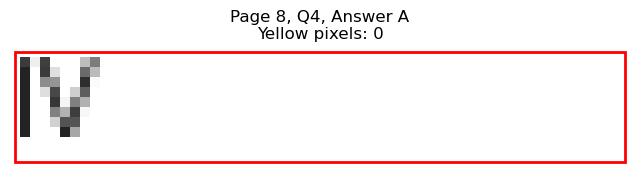

Page 8, Q4 - B: Detected box: x0=68.3, y0=330.9, x1=78.4, y1=342.0
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 32
Page 8, Q4, B: Yellow percentage: 0.0%


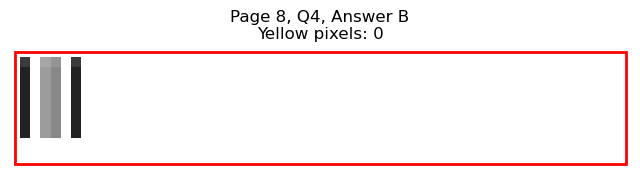

Page 8, Q4 - C: Detected box: x0=315.4, y0=318.3, x1=324.4, y1=329.4
Page 8, Q4, C: Yellow pixels: 60
Page 8, Q4, C: Total non-white pixels: 127
Page 8, Q4, C: Yellow percentage: 47.2%


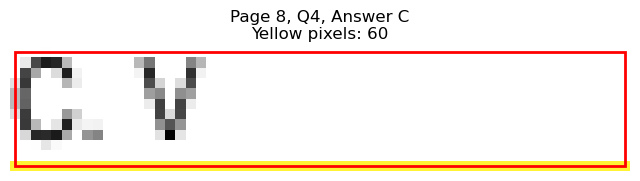

Page 8, Q4 - D: Detected box: x0=327.5, y0=330.9, x1=338.5, y1=342.0
Page 8, Q4, D: Yellow pixels: 708
Page 8, Q4, D: Total non-white pixels: 744
Page 8, Q4, D: Yellow percentage: 95.2%


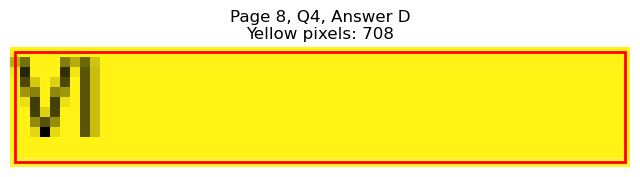


Page 8, Q4 - Selected Answer: D (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=368.8, x1=167.5, y1=379.9
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 643
Page 8, Q5, A: Yellow percentage: 0.0%


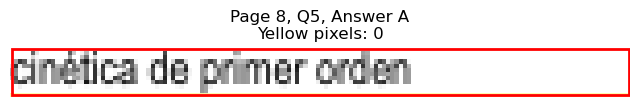

Page 8, Q5 - B: Detected box: x0=68.3, y0=381.4, x1=159.6, y1=392.5
Page 8, Q5, B: Yellow pixels: 1212
Page 8, Q5, B: Total non-white pixels: 1704
Page 8, Q5, B: Yellow percentage: 71.1%


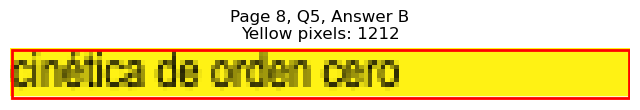

Page 8, Q5 - C: Detected box: x0=327.5, y0=368.8, x1=379.7, y1=379.9
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 278
Page 8, Q5, C: Yellow percentage: 0.0%


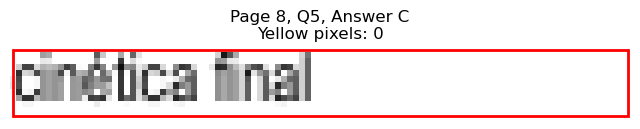

Page 8, Q5 - D: Detected box: x0=327.5, y0=381.4, x1=368.2, y1=392.5
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 211
Page 8, Q5, D: Yellow percentage: 0.0%


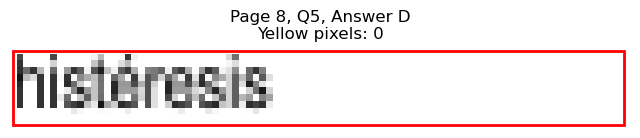


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=457.2, x1=78.4, y1=468.2
Page 8, Q6, A: Yellow pixels: 639
Page 8, Q6, A: Total non-white pixels: 671
Page 8, Q6, A: Yellow percentage: 95.2%


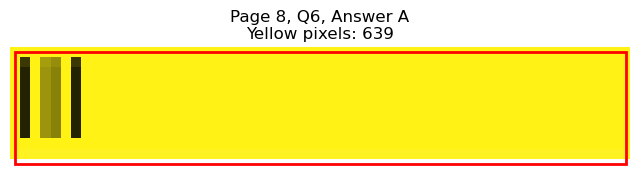

Page 8, Q6 - B: Detected box: x0=56.6, y0=469.8, x1=65.2, y1=480.8
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 66
Page 8, Q6, B: Yellow percentage: 0.0%


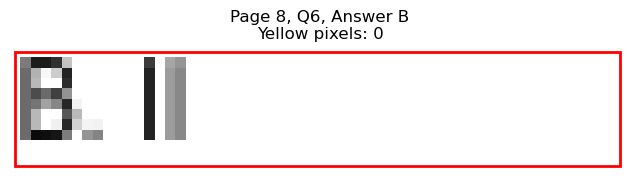

Page 8, Q6 - C: Detected box: x0=315.4, y0=457.2, x1=324.4, y1=468.2
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 54
Page 8, Q6, C: Yellow percentage: 0.0%


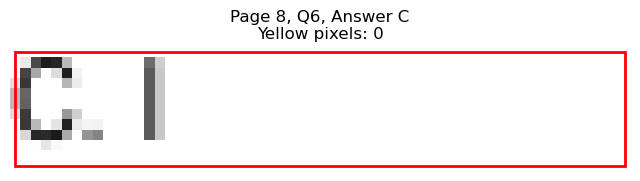

Page 8, Q6 - D: Detected box: x0=327.5, y0=469.8, x1=338.5, y1=480.8
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 43
Page 8, Q6, D: Yellow percentage: 0.0%


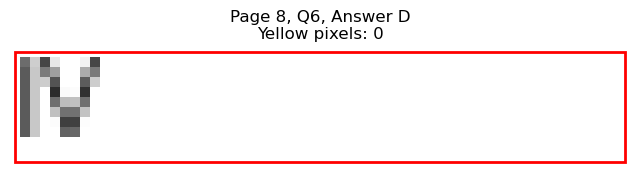


Page 8, Q6 - Selected Answer: A (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=520.3, x1=121.4, y1=531.3
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 277
Page 8, Q7, A: Yellow percentage: 0.0%


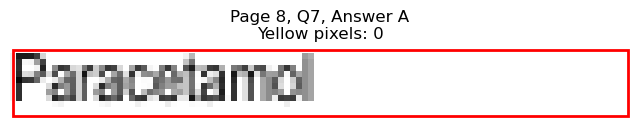

Page 8, Q7 - B: Detected box: x0=68.3, y0=532.9, x1=109.0, y1=543.9
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 190
Page 8, Q7, B: Yellow percentage: 0.0%


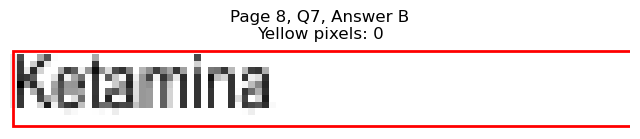

Page 8, Q7 - C: Detected box: x0=327.5, y0=520.3, x1=365.6, y1=531.3
Page 8, Q7, C: Yellow pixels: 89
Page 8, Q7, C: Total non-white pixels: 272
Page 8, Q7, C: Yellow percentage: 32.7%


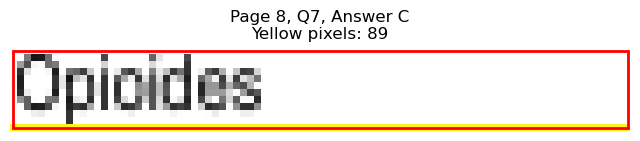

Page 8, Q7 - D: Detected box: x0=327.5, y0=532.9, x1=381.7, y1=543.9
Page 8, Q7, D: Yellow pixels: 1058
Page 8, Q7, D: Total non-white pixels: 1260
Page 8, Q7, D: Yellow percentage: 84.0%


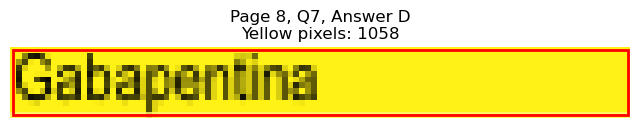


Page 8, Q7 - Selected Answer: D (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=583.4, x1=158.0, y1=594.4
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 465
Page 8, Q8, A: Yellow percentage: 0.0%


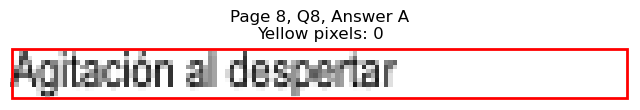

Page 8, Q8 - B: Detected box: x0=68.3, y0=596.0, x1=157.6, y1=607.0
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 456
Page 8, Q8, B: Yellow percentage: 0.0%


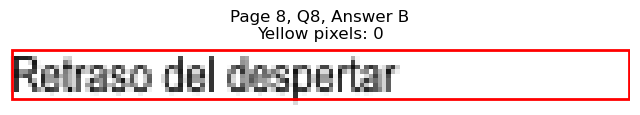

Page 8, Q8 - C: Detected box: x0=327.5, y0=583.4, x1=391.7, y1=594.4
Page 8, Q8, C: Yellow pixels: 115
Page 8, Q8, C: Total non-white pixels: 436
Page 8, Q8, C: Yellow percentage: 26.4%


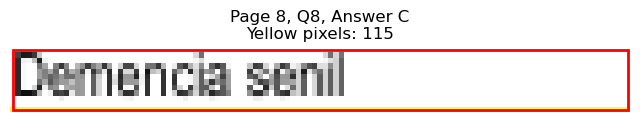

Page 8, Q8 - D: Detected box: x0=327.5, y0=596.0, x1=425.8, y1=607.0
Page 8, Q8, D: Yellow pixels: 1377
Page 8, Q8, D: Total non-white pixels: 1792
Page 8, Q8, D: Yellow percentage: 76.8%


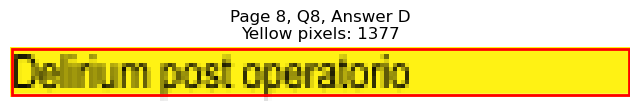


Page 8, Q8 - Selected Answer: D (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=646.5, x1=147.5, y1=657.6
Page 8, Q9, A: Yellow pixels: 1107
Page 8, Q9, A: Total non-white pixels: 1560
Page 8, Q9, A: Yellow percentage: 71.0%


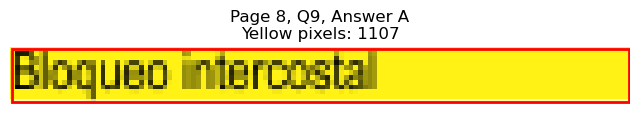

Page 8, Q9 - B: Detected box: x0=68.3, y0=659.1, x1=172.6, y1=670.2
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 555
Page 8, Q9, B: Yellow percentage: 0.0%


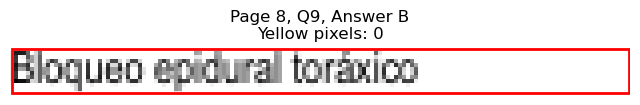

Page 8, Q9 - C: Detected box: x0=327.5, y0=646.5, x1=501.6, y1=657.6
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 852
Page 8, Q9, C: Yellow percentage: 0.0%


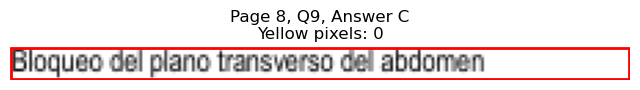

Page 8, Q9 - D: Detected box: x0=327.5, y0=659.1, x1=416.8, y1=670.2
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 476
Page 8, Q9, D: Yellow percentage: 0.0%


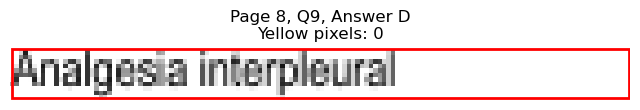


Page 8, Q9 - Selected Answer: A (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=68.3, y0=709.6, x1=91.8, y1=720.7
Page 8, Q10, A: Yellow pixels: 0
Page 8, Q10, A: Total non-white pixels: 107
Page 8, Q10, A: Yellow percentage: 0.0%


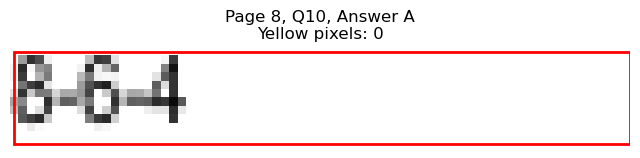

Page 8, Q10 - B: Detected box: x0=68.3, y0=722.2, x1=91.8, y1=733.3
Page 8, Q10, B: Yellow pixels: 0
Page 8, Q10, B: Total non-white pixels: 107
Page 8, Q10, B: Yellow percentage: 0.0%


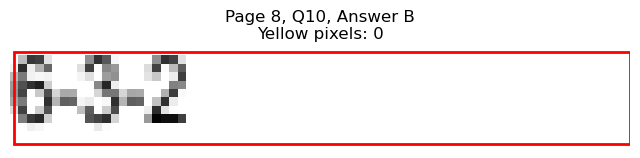

Page 8, Q10 - C: Detected box: x0=327.5, y0=709.6, x1=351.0, y1=720.7
Page 8, Q10, C: Yellow pixels: 74
Page 8, Q10, C: Total non-white pixels: 175
Page 8, Q10, C: Yellow percentage: 42.3%


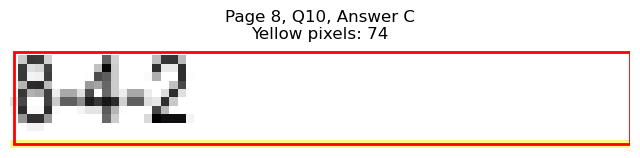

Page 8, Q10 - D: Detected box: x0=327.5, y0=722.2, x1=351.0, y1=733.3
Page 8, Q10, D: Yellow pixels: 740
Page 8, Q10, D: Total non-white pixels: 888
Page 8, Q10, D: Yellow percentage: 83.3%


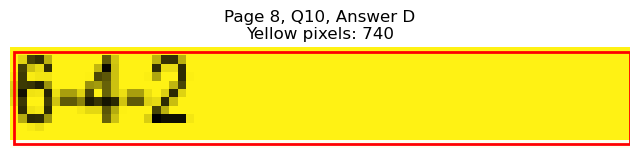


Page 8, Q10 - Selected Answer: D (based on yellow pixel count)





Page 9: Found 11 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=125.4, y1=114.8
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 293
Page 9, Q1, A: Yellow percentage: 0.0%


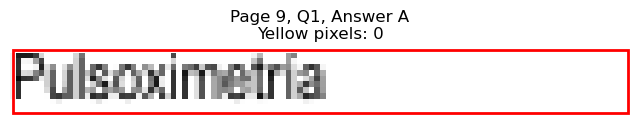

Page 9, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=117.5, y1=127.4
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 285
Page 9, Q1, B: Yellow percentage: 0.0%


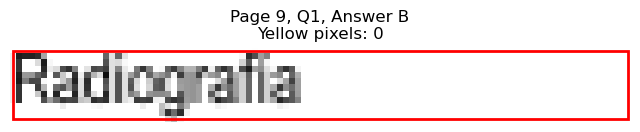

Page 9, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=379.7, y1=114.8
Page 9, Q1, C: Yellow pixels: 1010
Page 9, Q1, C: Total non-white pixels: 1236
Page 9, Q1, C: Yellow percentage: 81.7%


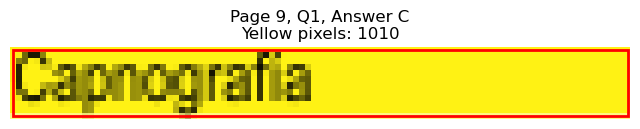

Page 9, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=381.1, y1=127.4
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 278
Page 9, Q1, D: Yellow percentage: 0.0%


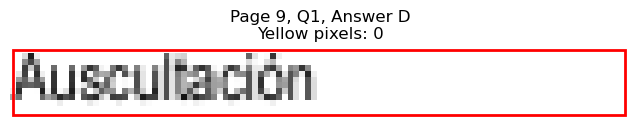


Page 9, Q1 - Selected Answer: C (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=154.3, x1=266.4, y1=165.3
Page 9, Q2, A: Yellow pixels: 249
Page 9, Q2, A: Total non-white pixels: 1238
Page 9, Q2, A: Yellow percentage: 20.1%


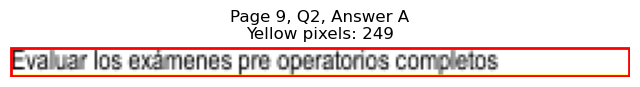

Page 9, Q2 - B: Detected box: x0=68.3, y0=166.9, x1=286.9, y1=177.9
Page 9, Q2, B: Yellow pixels: 2370
Page 9, Q2, B: Total non-white pixels: 3228
Page 9, Q2, B: Yellow percentage: 73.4%


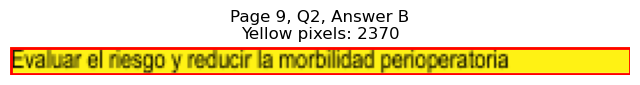

Page 9, Q2 - C: Detected box: x0=68.8, y0=179.5, x1=311.5, y1=190.5
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 1162
Page 9, Q2, C: Yellow percentage: 0.0%


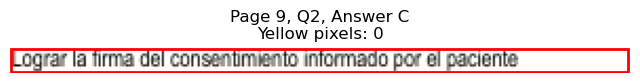

Page 9, Q2 - D: Detected box: x0=68.8, y0=192.1, x1=268.9, y1=203.1
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 1050
Page 9, Q2, D: Yellow percentage: 0.0%


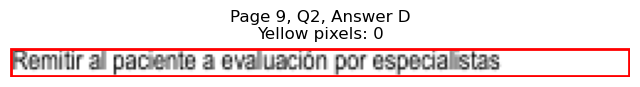


Page 9, Q2 - Selected Answer: B (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=242.6, x1=129.0, y1=253.6
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 311
Page 9, Q3, A: Yellow percentage: 0.0%


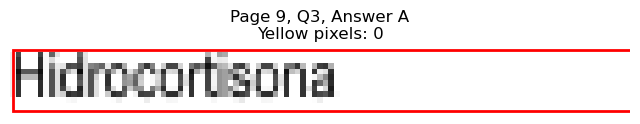

Page 9, Q3 - B: Detected box: x0=68.3, y0=255.2, x1=131.5, y1=266.2
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 290
Page 9, Q3, B: Yellow percentage: 0.0%


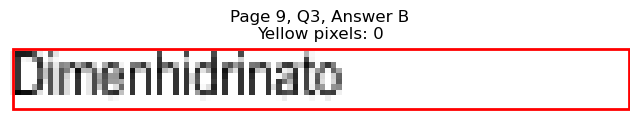

Page 9, Q3 - C: Detected box: x0=327.5, y0=242.6, x1=363.6, y1=253.6
Page 9, Q3, C: Yellow pixels: 87
Page 9, Q3, C: Total non-white pixels: 277
Page 9, Q3, C: Yellow percentage: 31.4%


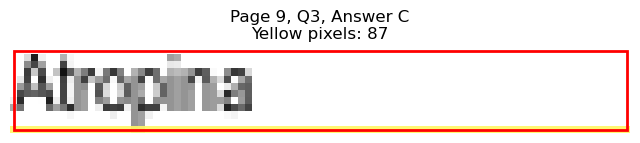

Page 9, Q3 - D: Detected box: x0=327.5, y0=255.2, x1=368.2, y1=266.2
Page 9, Q3, D: Yellow pixels: 849
Page 9, Q3, D: Total non-white pixels: 1012
Page 9, Q3, D: Yellow percentage: 83.9%


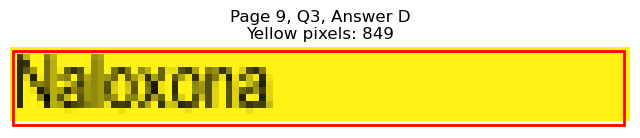


Page 9, Q3 - Selected Answer: D (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=318.3, x1=121.9, y1=329.4
Page 9, Q4, A: Yellow pixels: 939
Page 9, Q4, A: Total non-white pixels: 1248
Page 9, Q4, A: Yellow percentage: 75.2%


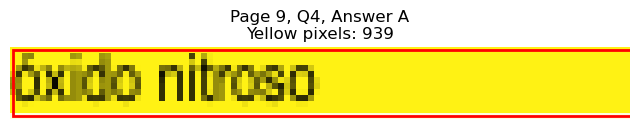

Page 9, Q4 - B: Detected box: x0=68.3, y0=330.9, x1=117.5, y1=342.0
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 257
Page 9, Q4, B: Yellow percentage: 0.0%


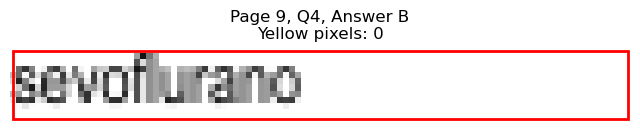

Page 9, Q4 - C: Detected box: x0=327.5, y0=318.3, x1=372.1, y1=329.4
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 232
Page 9, Q4, C: Yellow percentage: 0.0%


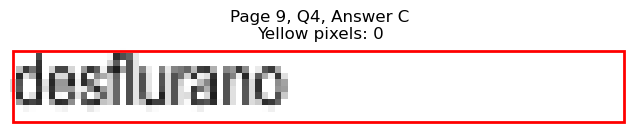

Page 9, Q4 - D: Detected box: x0=327.5, y0=330.9, x1=369.1, y1=342.0
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 210
Page 9, Q4, D: Yellow percentage: 0.0%


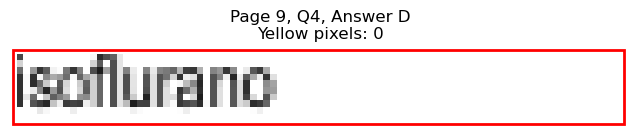


Page 9, Q4 - Selected Answer: A (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=394.0, x1=111.4, y1=405.1
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 239
Page 9, Q5, A: Yellow percentage: 0.0%


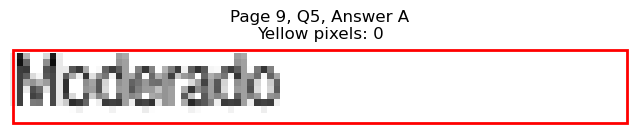

Page 9, Q5 - B: Detected box: x0=68.3, y0=406.6, x1=91.3, y1=417.7
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 121
Page 9, Q5, B: Yellow percentage: 0.0%


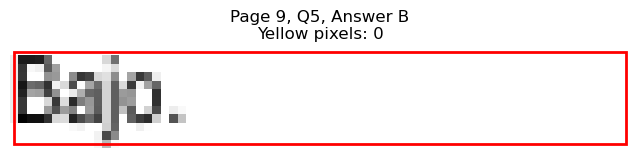

Page 9, Q5 - C: Detected box: x0=327.5, y0=394.0, x1=345.6, y1=405.1
Page 9, Q5, C: Yellow pixels: 696
Page 9, Q5, C: Total non-white pixels: 759
Page 9, Q5, C: Yellow percentage: 91.7%


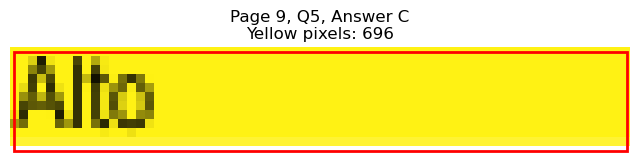

Page 9, Q5 - D: Detected box: x0=327.5, y0=406.6, x1=390.8, y1=417.7
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 323
Page 9, Q5, D: Yellow percentage: 0.0%


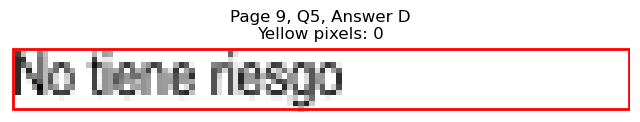


Page 9, Q5 - Selected Answer: C (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=457.2, x1=250.3, y1=468.2
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 857
Page 9, Q6, A: Yellow percentage: 0.0%


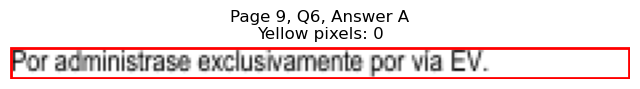

Page 9, Q6 - B: Detected box: x0=68.3, y0=469.8, x1=274.3, y1=480.8
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 1111
Page 9, Q6, B: Yellow percentage: 0.0%


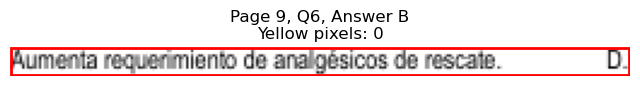

Page 9, Q6 - C: Detected box: x0=327.5, y0=457.2, x1=452.4, y1=468.2
Page 9, Q6, C: Yellow pixels: 1471
Page 9, Q6, C: Total non-white pixels: 1938
Page 9, Q6, C: Yellow percentage: 75.9%


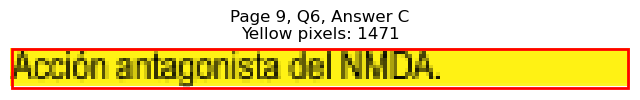

Page 9, Q6 - D: Detected box: x0=327.5, y0=469.8, x1=436.8, y1=480.8
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 531
Page 9, Q6, D: Yellow percentage: 0.0%


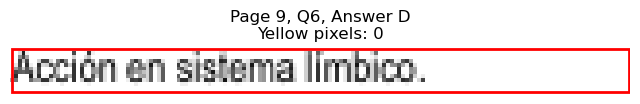


Page 9, Q6 - Selected Answer: C (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=520.3, x1=150.0, y1=531.3
Page 9, Q7, A: Yellow pixels: 132
Page 9, Q7, A: Total non-white pixels: 536
Page 9, Q7, A: Yellow percentage: 24.6%


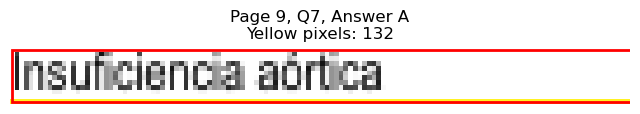

Page 9, Q7 - B: Detected box: x0=68.3, y0=532.9, x1=145.0, y1=543.9
Page 9, Q7, B: Yellow pixels: 1238
Page 9, Q7, B: Total non-white pixels: 1524
Page 9, Q7, B: Yellow percentage: 81.2%


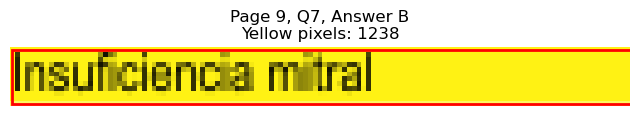

Page 9, Q7 - C: Detected box: x0=327.5, y0=520.3, x1=398.8, y1=531.3
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 360
Page 9, Q7, C: Yellow percentage: 0.0%


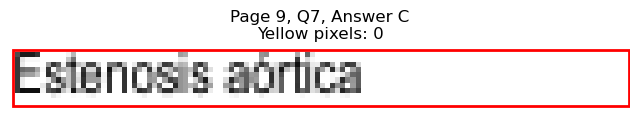

Page 9, Q7 - D: Detected box: x0=327.5, y0=532.9, x1=436.3, y1=543.9
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 596
Page 9, Q7, D: Yellow percentage: 0.0%


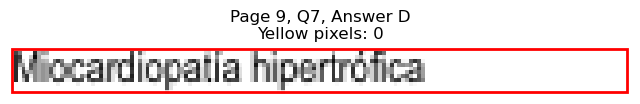


Page 9, Q7 - Selected Answer: B (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=583.4, x1=149.5, y1=594.4
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 416
Page 9, Q8, A: Yellow percentage: 0.0%


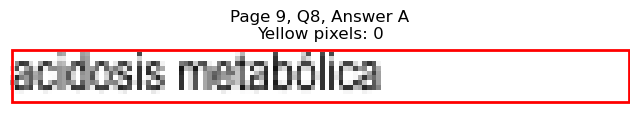

Page 9, Q8 - B: Detected box: x0=68.3, y0=596.0, x1=151.6, y1=607.0
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 429
Page 9, Q8, B: Yellow percentage: 0.0%


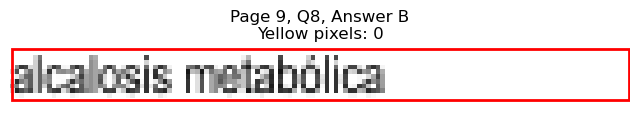

Page 9, Q8 - C: Detected box: x0=327.5, y0=583.4, x1=413.4, y1=594.4
Page 9, Q8, C: Yellow pixels: 1180
Page 9, Q8, C: Total non-white pixels: 1644
Page 9, Q8, C: Yellow percentage: 71.8%


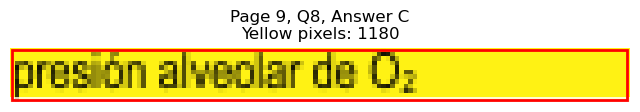

Page 9, Q8 - D: Detected box: x0=327.5, y0=596.0, x1=414.2, y1=607.0
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 444
Page 9, Q8, D: Yellow percentage: 0.0%


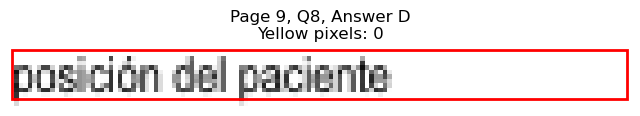


Page 9, Q8 - Selected Answer: C (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=633.9, x1=147.5, y1=645.0
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 515
Page 9, Q9, A: Yellow percentage: 0.0%


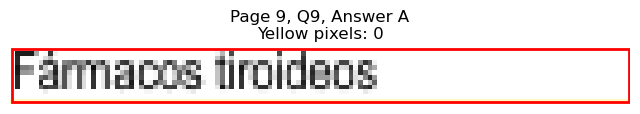

Page 9, Q9 - B: Detected box: x0=68.3, y0=646.5, x1=97.8, y1=657.6
Page 9, Q9, B: Yellow pixels: 760
Page 9, Q9, B: Total non-white pixels: 960
Page 9, Q9, B: Yellow percentage: 79.2%


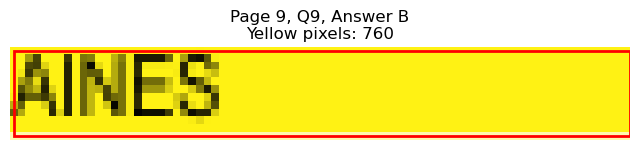

Page 9, Q9 - C: Detected box: x0=327.5, y0=633.9, x1=365.6, y1=645.0
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 184
Page 9, Q9, C: Yellow percentage: 0.0%


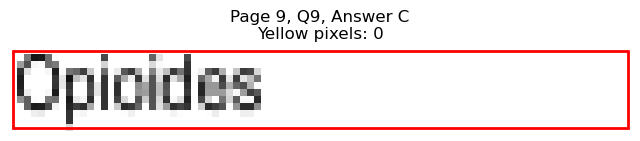

Page 9, Q9 - D: Detected box: x0=327.5, y0=646.5, x1=388.3, y1=657.6
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 334
Page 9, Q9, D: Yellow percentage: 0.0%


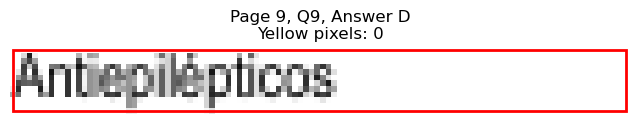


Page 9, Q9 - Selected Answer: B (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=68.3, y0=697.0, x1=100.9, y1=708.1
Page 9, Q10, A: Yellow pixels: 0
Page 9, Q10, A: Total non-white pixels: 161
Page 9, Q10, A: Yellow percentage: 0.0%


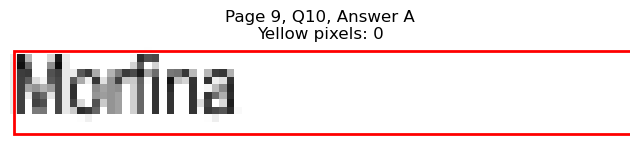

Page 9, Q10 - B: Detected box: x0=68.3, y0=709.6, x1=109.0, y1=720.7
Page 9, Q10, B: Yellow pixels: 0
Page 9, Q10, B: Total non-white pixels: 190
Page 9, Q10, B: Yellow percentage: 0.0%


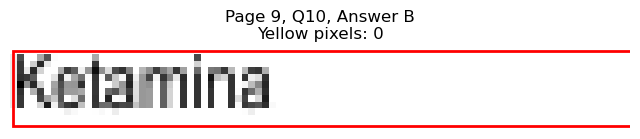

Page 9, Q10 - C: Detected box: x0=327.5, y0=697.0, x1=375.1, y1=708.1
Page 9, Q10, C: Yellow pixels: 903
Page 9, Q10, C: Total non-white pixels: 1089
Page 9, Q10, C: Yellow percentage: 82.9%


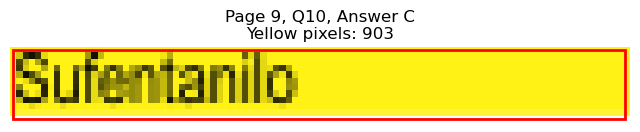

Page 9, Q10 - D: Detected box: x0=327.5, y0=709.6, x1=381.6, y1=720.7
Page 9, Q10, D: Yellow pixels: 0
Page 9, Q10, D: Total non-white pixels: 283
Page 9, Q10, D: Yellow percentage: 0.0%


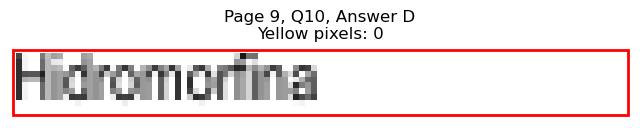


Page 9, Q10 - Selected Answer: C (based on yellow pixel count)




Page 9, Q11 - A: Detected box: x0=68.3, y0=747.4, x1=107.9, y1=758.5
Page 9, Q11, A: Yellow pixels: 90
Page 9, Q11, A: Total non-white pixels: 269
Page 9, Q11, A: Yellow percentage: 33.5%


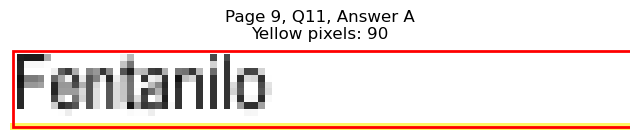

Page 9, Q11 - B: Detected box: x0=68.3, y0=760.2, x1=102.8, y1=771.2
Page 9, Q11, B: Yellow pixels: 814
Page 9, Q11, B: Total non-white pixels: 935
Page 9, Q11, B: Yellow percentage: 87.1%


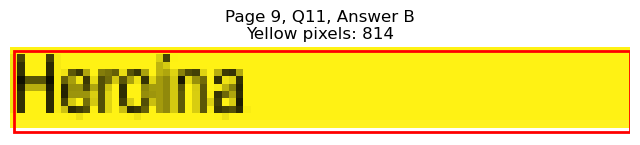

Page 9, Q11 - C: Detected box: x0=327.5, y0=747.4, x1=370.1, y1=758.5
Page 9, Q11, C: Yellow pixels: 0
Page 9, Q11, C: Total non-white pixels: 226
Page 9, Q11, C: Yellow percentage: 0.0%


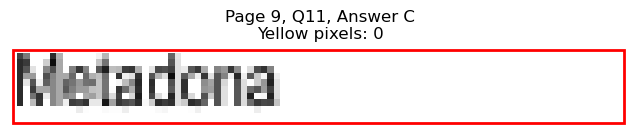

Page 9, Q11 - D: Detected box: x0=327.5, y0=760.2, x1=385.2, y1=771.2
Page 9, Q11, D: Yellow pixels: 0
Page 9, Q11, D: Total non-white pixels: 301
Page 9, Q11, D: Yellow percentage: 0.0%


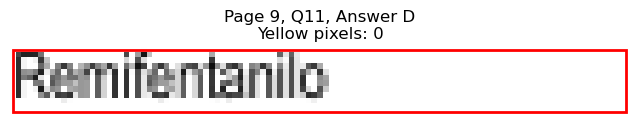


Page 9, Q11 - Selected Answer: B (based on yellow pixel count)





Page 10: Found 5 questions
Page 10, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=160.6, y1=102.2
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 475
Page 10, Q1, A: Yellow percentage: 0.0%


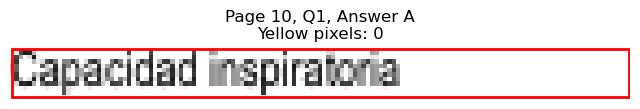

Page 10, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=186.6, y1=114.8
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 585
Page 10, Q1, B: Yellow percentage: 0.0%


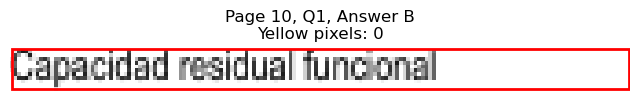

Page 10, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=432.8, y1=102.2
Page 10, Q1, C: Yellow pixels: 156
Page 10, Q1, C: Total non-white pixels: 851
Page 10, Q1, C: Yellow percentage: 18.3%


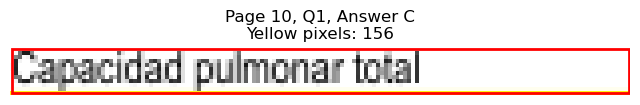

Page 10, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=391.7, y1=114.8
Page 10, Q1, D: Yellow pixels: 1123
Page 10, Q1, D: Total non-white pixels: 1380
Page 10, Q1, D: Yellow percentage: 81.4%


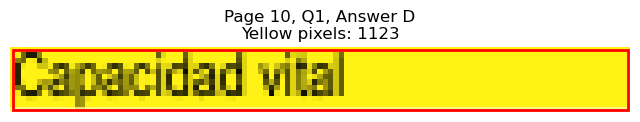


Page 10, Q1 - Selected Answer: D (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=68.3, y0=141.7, x1=183.1, y1=152.7
Page 10, Q2, A: Yellow pixels: 166
Page 10, Q2, A: Total non-white pixels: 750
Page 10, Q2, A: Yellow percentage: 22.1%


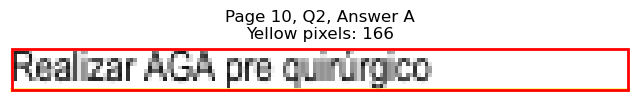

Page 10, Q2 - B: Detected box: x0=68.3, y0=154.3, x1=270.5, y1=165.3
Page 10, Q2, B: Yellow pixels: 1613
Page 10, Q2, B: Total non-white pixels: 2601
Page 10, Q2, B: Yellow percentage: 62.0%


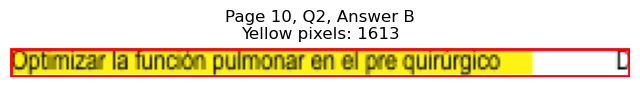

Page 10, Q2 - C: Detected box: x0=327.5, y0=141.7, x1=484.0, y1=152.7
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 803
Page 10, Q2, C: Yellow percentage: 0.0%


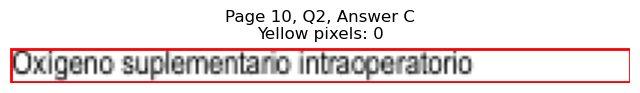

Page 10, Q2 - D: Detected box: x0=327.5, y0=154.3, x1=504.6, y1=165.3
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 869
Page 10, Q2, D: Yellow percentage: 0.0%


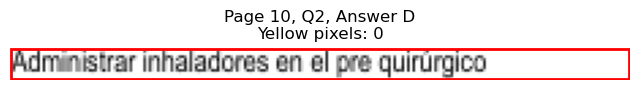


Page 10, Q2 - Selected Answer: B (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=68.3, y0=192.1, x1=115.0, y1=203.1
Page 10, Q3, A: Yellow pixels: 902
Page 10, Q3, A: Total non-white pixels: 1067
Page 10, Q3, A: Yellow percentage: 84.5%


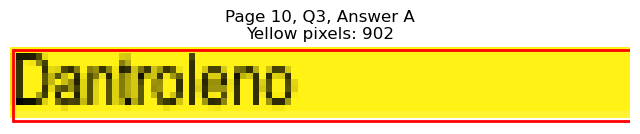

Page 10, Q3 - B: Detected box: x0=68.3, y0=204.7, x1=114.4, y1=215.7
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 233
Page 10, Q3, B: Yellow percentage: 0.0%


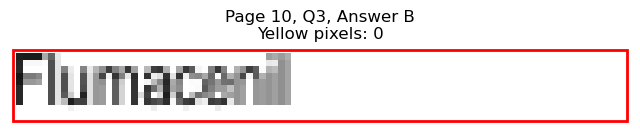

Page 10, Q3 - C: Detected box: x0=327.5, y0=192.1, x1=368.2, y1=203.1
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 207
Page 10, Q3, C: Yellow percentage: 0.0%


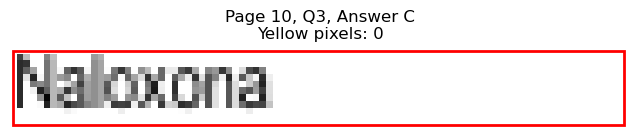

Page 10, Q3 - D: Detected box: x0=327.5, y0=204.7, x1=375.6, y1=215.7
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 251
Page 10, Q3, D: Yellow percentage: 0.0%


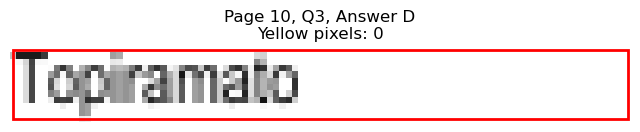


Page 10, Q3 - Selected Answer: A (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=68.3, y0=255.2, x1=197.6, y1=266.2
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 668
Page 10, Q4, A: Yellow percentage: 0.0%


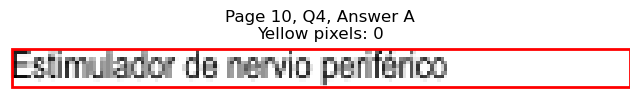

Page 10, Q4 - B: Detected box: x0=68.3, y0=267.8, x1=136.4, y1=278.8
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 382
Page 10, Q4, B: Yellow percentage: 0.0%


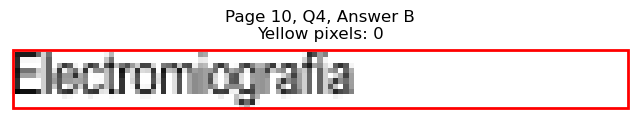

Page 10, Q4 - C: Detected box: x0=327.5, y0=255.2, x1=415.2, y1=266.2
Page 10, Q4, C: Yellow pixels: 1228
Page 10, Q4, C: Total non-white pixels: 1532
Page 10, Q4, C: Yellow percentage: 80.2%


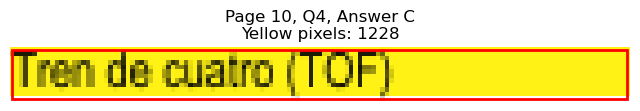

Page 10, Q4 - D: Detected box: x0=327.5, y0=267.8, x1=399.7, y1=278.8
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 385
Page 10, Q4, D: Yellow percentage: 0.0%


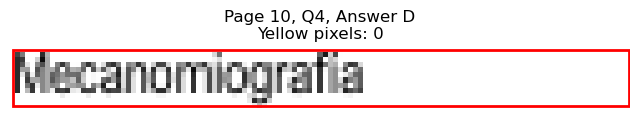


Page 10, Q4 - Selected Answer: C (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=68.3, y0=318.3, x1=192.1, y1=329.4
Page 10, Q5, A: Yellow pixels: 1451
Page 10, Q5, A: Total non-white pixels: 2100
Page 10, Q5, A: Yellow percentage: 69.1%


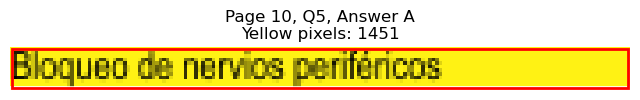

Page 10, Q5 - B: Detected box: x0=68.3, y0=330.9, x1=213.8, y1=342.0
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 721
Page 10, Q5, B: Yellow percentage: 0.0%


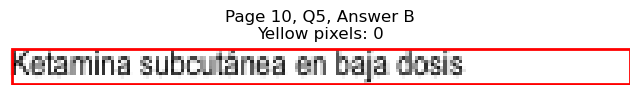

Page 10, Q5 - C: Detected box: x0=327.5, y0=318.3, x1=480.0, y1=329.4
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 770
Page 10, Q5, C: Yellow percentage: 0.0%


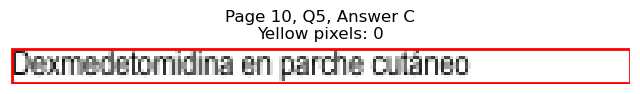

Page 10, Q5 - D: Detected box: x0=327.5, y0=330.9, x1=421.8, y1=342.0
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 500
Page 10, Q5, D: Yellow percentage: 0.0%


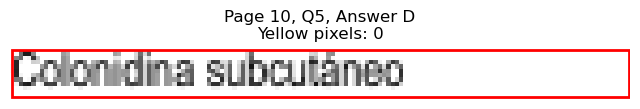


Page 10, Q5 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   ¿Cuál es el bloqueante neuromuscular no despol...
1   Durante la visita anestésica es importante que...
2   ¿Qué anestésico endovenoso actúa como agonista...
3   Mujer de 53 años, presenta de forma súbita taq...
4   Primigesta de 38 semanas, se realiza cesárea s...
..                                                ...
95  En relación al aparato pulmonar. ¿Cuál es la c...
96  Varón de 55 años, con EPOC, será operado de ad...
97  ¿Cuál es el fármaco utilizado para tratar la h...
98  Varón de 50 años, operado de adenoma prostátic...
99  Varón de 72 años, con obesidad y apnea del sue...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                          Mivacurio   
1               Child-Turcotte- Pugh   
2                    Dexmedetomidina   
3                          Adenosina   
4                  Hematoma epidural   
..                               ...   
95            Capacidad inspiratoria   
96       Realizar AGA pre quirúrgico   
97                        Dantroleno   
98  Estimulador de nervio periférico   
99    Bloqueo de nervios periféricos   

                                             option_B  \
0                                      Succinilcolina   
1                                             Caprini   
2                                          Droperidol   
3                                          Amiodarona   
4                                           Lumbalgia   
..                                                ...   
95                       Capacidad residual funcional   
96  Optimizar la función pulmonar en el pre quirúr...   
97                                         Flumacenil   
98                                   Electromiografía   
99                  Ketamina subcutánea en baja dosis   

                                 option_C  \
0                               Atracurio   
1                            CHA2DS2-VASc   
2                                Ketamina   
3                              Adrenalina   
4                    Hernia discal L3- L4   
..                                    ...   
95               Capacidad pulmonar total   
96  Oxígeno suplementario intraoperatorio   
97                               Naloxona   
98                   Tren de cuatro (TOF)   
99      Dexmedetomidina en parche cutáneo   

                                        option_D  
0                                      Vecuronio  
1                                            ASA  
2                                      Etomidato  
3                       Cardioversión sincrónica  
4              Lesión de ligamento supraespinoso  
..                                           ...  
95                               Capacidad vital  
96  Administrar inhaladores en el pre quirúrgico  
97                                    Topiramato  
98                               Mecanomiografía  
99                         Colonidina subcutáneo  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               A
1               B
2               A
3               D
4               A
..            ...
95              D
96              B
97              A
98              C
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   ¿Cuál es el bloqueante neuromuscular no despol...   
1   Durante la visita anestésica es importante que...   
2   ¿Qué anestésico endovenoso actúa como agonista...   
3   Mujer de 53 años, presenta de forma súbita taq...   
4   Primigesta de 38 semanas, se realiza cesárea s...   
..                                                ...   
95  En relación al aparato pulmonar. ¿Cuál es la c...   
96  Varón de 55 años, con EPOC, será operado de ad...   
97  ¿Cuál es el fármaco utilizado para tratar la h...   
98  Varón de 50 años, operado de adenoma prostátic...   
99  Varón de 72 años, con obesidad y apnea del sue...   

                            option_A  \
0                          Mivacurio   
1               Child-Turcotte- Pugh   
2                    Dexmedetomidina   
3                          Adenosina   
4                  Hematoma epidural   
..                               ...   
95            Capacidad inspiratoria   
96       Realizar AGA pre quirúrgico   
97                        Dantroleno   
98  Estimulador de nervio periférico   
99    Bloqueo de nervios periféricos   

                                             option_B  \
0                                      Succinilcolina   
1                                             Caprini   
2                                          Droperidol   
3                                          Amiodarona   
4                                           Lumbalgia   
..                                                ...   
95                       Capacidad residual funcional   
96  Optimizar la función pulmonar en el pre quirúr...   
97                                         Flumacenil   
98                                   Electromiografía   
99                  Ketamina subcutánea en baja dosis   

                                 option_C  \
0                               Atracurio   
1                            CHA2DS2-VASc   
2                                Ketamina   
3                              Adrenalina   
4                    Hernia discal L3- L4   
..                                    ...   
95               Capacidad pulmonar total   
96  Oxígeno suplementario intraoperatorio   
97                               Naloxona   
98                   Tren de cuatro (TOF)   
99      Dexmedetomidina en parche cutáneo   

                                        option_D correct_answer  
0                                      Vecuronio              A  
1                                            ASA              B  
2                                      Etomidato              A  
3                       Cardioversión sincrónica              D  
4              Lesión de ligamento supraespinoso              A  
..                                           ...            ...  
95                               Capacidad vital              D  
96  Administrar inhaladores en el pre quirúrgico              B  
97                                    Topiramato              A  
98                               Mecanomiografía              C  
99                         Colonidina subcutáneo              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Documents/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2025/ANESTESIOLOGIA.csv
